In [1]:
MOVE_PENALTY = -0.05 # -0.05
FIND_REWARD = 1.0
# Robot alwasys starts in room 0

In [2]:
import numpy as np

'''
If obs_sigma < sigma0 → robot trust data more than the prior.
If obs_sigma > sigma0 → robot trust your prior more than the data.
If obs_sigma = sigma0 → robot give equal trust to both.
'''
# Obs sigma: confidence on observed reward
# THIS IS A META PARAMTER DEFINATELY
# SMALL (0.1 )OBS SIGMA: trust more real observations and update mu faster, sigma decreases with less uncertainty faster.
# BIG (10.0) OBS SIGMA: trust more the prior, mu updates slower. Sigma decreases slower 
def calculate_obs_sigma(rewards: list):
    mean_reward = np.mean(rewards)
    empirical_variance = np.var(rewards, ddof=1)  # ddof=1 da varianza muestral (unbiased)
    empirical_std = empirical_variance ** 0.5
    return empirical_std


In [3]:
class BayesianRewardEstimator:
    def __init__(self, mu0=3.5, sigma0=1.0, obs_sigma=0.1):
        self.mu = mu0
        self.sigma2 = sigma0 ** 2
        self.obs_sigma2 = obs_sigma ** 2
        self.n = 0
        self.sum_rewards = 0.0

    def update(self, reward):
        self.n += 1
        self.sum_rewards += reward

        precision_prior = 1 / self.sigma2
        precision_obs = self.n / self.obs_sigma2

        self.sigma2 = 1 / (precision_prior + precision_obs)
        self.mu = self.sigma2 * (precision_prior * self.mu + (self.sum_rewards / self.obs_sigma2))
        #print("update belief finish")

    def current_posterior(self):
        return self.mu, self.sigma2 ** 0.5


## EXPERIMENT SETUP: BALLS IN ROOMS

In [4]:
class BallEnvDetectable:
    def __init__(self,num_rooms=4, num_blue=3, num_red=1):
        self.num_rooms = num_rooms
        self.num_blue = num_blue
        self.num_red = num_red
        self.balls = []
        self.found_balls = set()
        self.robot_room = 0
        self.blue_cluster_prob = 0.9
        self.p_detect = 0.9
        self.p_explore = 0.1
        self.connections = self._default_connections()

    def _default_connections(self):
        # Conexión por defecto: todos conectados con todos (completo)
        return {i: [j for j in range(self.num_rooms) if j != i] for i in range(self.num_rooms)}

    def set_blue_cluster_prob(self, prob: float):
        self.blue_cluster_prob = prob

    def set_detection_params(self, p_detect: float, p_explore: float):
        self.p_detect = p_detect
        self.p_explore = p_explore

    def set_manual_ball_positions(self, positions: list[tuple[str, int]]):
        self.balls = positions.copy()
        self.found_balls = set()

    def set_connections(self, connections: dict[int, list[int]]):
        """
        Define conexiones entre habitaciones. Ejemplo:
        {
            0: [1],
            1: [0, 2],
            2: [1, 3],
            3: [2]
        }
        """
        self.connections = connections

    def reset(self):
        self.found_balls = set()

        if not self.balls:
            self.balls = []

            if random.random() < self.blue_cluster_prob:
                blue_room = random.randint(0, self.num_rooms - 1)
                for _ in range(self.num_blue):
                    self.balls.append(('blue', blue_room))
            else:
                for _ in range(self.num_blue):
                    self.balls.append(('blue', random.randint(0, self.num_rooms - 1)))

            for _ in range(self.num_red):
                self.balls.append(('red', random.randint(0, self.num_rooms - 1)))

        self.robot_room = 0 # Robot alwasys starts in room 0
        #random.randint(0, self.num_rooms - 1)
        return self.robot_room

    def detect_ball(self):
        for i, (color, room) in enumerate(self.balls):
            if room == self.robot_room and i not in self.found_balls:
                if random.random() < self.p_detect:
                    return i, color
        return None

    def step(self, target_room):
        if target_room not in self.connections.get(self.robot_room, []):
            raise ValueError(f"Invalid move: no connection from Room {self.robot_room} to Room {target_room}")

        reward = MOVE_PENALTY
        self.robot_room = target_room
        ball_found = None

        for i, (color, room) in enumerate(self.balls):
            if room == self.robot_room and i not in self.found_balls:
                if random.random() < self.p_detect:
                    self.found_balls.add(i)
                    reward += FIND_REWARD
                    ball_found = (i, color)
                break

        done = len(self.found_balls) == len(self.balls)
        return self.robot_room, reward, done, ball_found


## POLICY DEFINITION STAY IF BLUE BALL DETECTED

In [5]:
# Versión sin modificar de run_policy_with_detection pero que permite pasar un estimador bayesiano opcional
import random
import numpy as np  # si usas operaciones de numpy también


def run_policy_with_detection(env: BallEnvDetectable, max_steps=50, estimator=None):
    state = env.reset()
    total_reward = 0
    steps_taken = 0
    visited = set()
    empty_rooms = set()
    blue_rooms_memory = set()
    found_ids_last_step = set()

    print("\n🧪 Initial ball positions:")
    for i, (color, room) in enumerate(env.balls):
        print(f"   Ball {i}: {color.upper()} in Room {room}")
    print(f"\n🚀 Robot starting in Room {state}\n")

    for _ in range(max_steps):
        visited.add(state)

        # Detectar si hay una bola visible (probabilística)
        detection = env.detect_ball()

        if detection:
            idx, color = detection
            print(f"👁️  Detected possible {color.upper()} ball in Room {state}")
        else:
            print(f"🙈 No balls detected in Room {state}")

        # Decidir acción
        if detection and color == "blue":
            if random.random() < env.p_explore:
                # Explorar otra sala aunque haya azul
                candidate_rooms = [r for r in range(env.num_rooms) if r != state and r not in empty_rooms]
                if not candidate_rooms:
                    candidate_rooms = [r for r in range(env.num_rooms) if r != state]
                next_room = random.choice(candidate_rooms)
                print(f"   🤷 Exploring another room despite seeing blue.")
            else:
                next_room = state  # quedarse
        elif detection:
            next_room = state  # quedarse por bola no azul
        else:
            candidate_rooms = [r for r in range(env.num_rooms) if r != state and r not in empty_rooms]
            if not candidate_rooms:
                candidate_rooms = [r for r in range(env.num_rooms) if r != state]
            next_room = random.choice(candidate_rooms)

        # Paso de entorno
        prev_state = state
        state, reward, done, ball_found = env.step(next_room)
        total_reward += reward
        steps_taken += 1

        print(f"🔄 STEP {steps_taken} — Moved from Room {prev_state} → Room {next_room}")

        if ball_found:
            idx, color = ball_found
            print(f"   🎯 Found new ball: {color.upper()} (ID {idx})")
            if color == "blue":
                blue_rooms_memory.add(state)
        else:
            print(f"   😐 No new balls found in this room")

        # Si no encontró nada, marcar como vacía
        remaining_unknown = any(
            room == state and i not in env.found_balls for i, (_, room) in enumerate(env.balls)
        )
        if not ball_found and not remaining_unknown:
            empty_rooms.add(state)
            print(f"   🧱 Marking Room {state} as empty.")

        print(f"   💰 Reward: {reward:.2f} | Total: {total_reward:.2f}")
        print(f"   ✅ Balls found: {len(env.found_balls)} / 4")
        print(f"   🗺️  Visited: {sorted(visited)} | Empty: {sorted(empty_rooms)} | Memory(Blue): {sorted(blue_rooms_memory)}")
        print("---------------------------------------------------\n")

        if done:
            print("🎉 ✅ All balls found!")
            break
    else:
        print("⚠️ Max steps reached without finding all balls.")

    print(f"🏁 Finished after {steps_taken} steps | Total reward: {total_reward:.2f}")

    if estimator:
        print(f"🔢 Updating with total reward: {total_reward:.2f}")

        estimator.update(total_reward)

    plot_room_ball_distribution(env)
    return total_reward, steps_taken



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

def plot_room_ball_distribution(env: BallEnvDetectable):
    ball_count = np.zeros(env.num_rooms, dtype=int)
    ball_labels = [[] for _ in range(env.num_rooms)]

    for i, (color, room) in enumerate(env.balls):
        ball_count[room] += 1
        label = color[0].upper()
        if i in env.found_balls:
            label += '✓'
        ball_labels[room].append(label)

    ball_labels[env.robot_room].append("🤖")

    # Calcular dimensiones cuadradas más cercanas para el reshape dinámico
    rows = math.floor(math.sqrt(env.num_rooms))
    cols = math.ceil(env.num_rooms / rows)

    # Ajustar a tamaño correcto rellenando si es necesario
    total_cells = rows * cols
    if total_cells > env.num_rooms:
        ball_count = np.concatenate([ball_count, np.zeros(total_cells - env.num_rooms, dtype=int)])
        ball_labels += [''] * (total_cells - env.num_rooms)

    grid = ball_count.reshape((rows, cols))
    label_grid = np.array([
        '\n'.join(ball_labels[i]) if isinstance(ball_labels[i], list) else ''
        for i in range(total_cells)
    ]).reshape((rows, cols))

    plt.figure(figsize=(cols + 2, rows + 2))
    ax = sns.heatmap(grid, annot=label_grid, fmt='', cmap="YlGnBu", cbar=False,
                     linewidths=1, linecolor='gray', square=True)

    for y in range(rows):
        for x in range(cols):
            room_id = y * cols + x
            if room_id < env.num_rooms:
                ax.text(x + 0.5, y + 0.9, f"Room {room_id}", color='black',
                        ha='center', va='bottom', fontsize=9)

    plt.title("Room Map with Ball Distribution")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()


## EXPERIMENT SETUP - RUN POLICY STAY IF BLUE BALL FOUND 

📌 Prior belief: μ₀ = 0.00, σ₀ = 1.5000

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 2 — Moved from Room 8 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 8] | Empty: [2, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️  

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


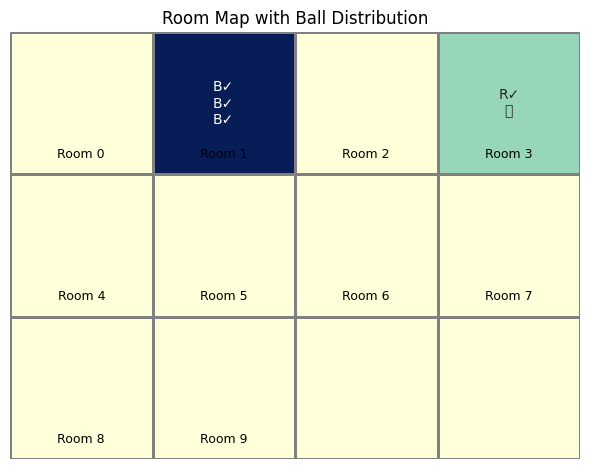

📌 Posterior belief: μ = 1.78, σ = 1.0607


In [7]:
# Bayesian prior belief
est = BayesianRewardEstimator(mu0=0.0, sigma0=1.5, obs_sigma=1.5) # obs_sigma=0.5 observations are reliable
print(f"📌 Prior belief: μ₀ = {est.mu:.2f}, σ₀ = {est.sigma2 ** 0.5:.4f}")
# Number of balls in each room by color
NUM_ROOMS = 10
env = BallEnvDetectable(NUM_ROOMS,num_blue=3, num_red=1)
# Probability that blue balls are all in the same room
env.set_blue_cluster_prob(0.9) # 0.9
# Probability of sucesful local detection and exploration chance out of blue room even when blue ball detected.
env.set_detection_params(p_detect=0.9, p_explore=0.0)

'''
env.set_connections({
    0: [0, 1, 2, 3],
    1: [0, 1, 2, 3],
    2: [0, 1, 2, 3],
    3: [0, 1, 2, 3]
})
'''

all_to_all = {i: list(range(NUM_ROOMS)) for i in range(NUM_ROOMS)}
env.set_connections(all_to_all)
# Manual setup of ball location

''' original
env.set_manual_ball_positions([
    ('blue', 1), ('blue', 1), ('blue', 1),  # tres bolas azules
    ('red', 4)                              # una roja
])
'''

env.set_manual_ball_positions([
    ('blue', 1), ('blue', 1), ('blue', 1),  # tres bolas azules
    ('red', 3)                              # una roja
])


# Running policy 1, location
run_policy_with_detection(env, estimator=est)
print(f"📌 Posterior belief: μ = {est.mu:.2f}, σ = {est.sigma2 ** 0.5:.4f}")


## RUNNING POLICY 1 many times

📌 Prior belief: μ₀ = 0.00, σ₀ = 1.5000

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
----------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


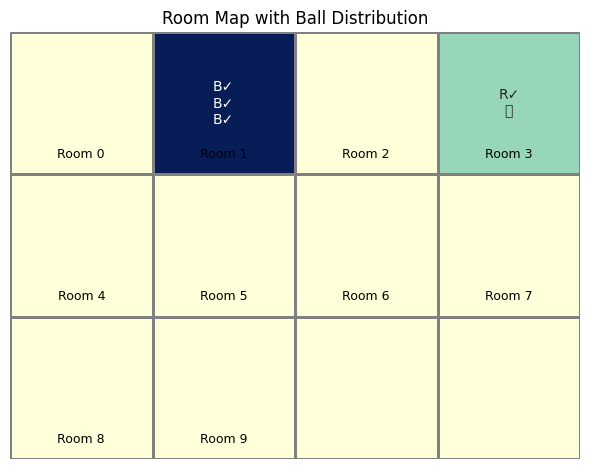

📌 Posterior belief: μ = 1.65, σ = 1.0607

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 9] | Empty: [2, 9] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


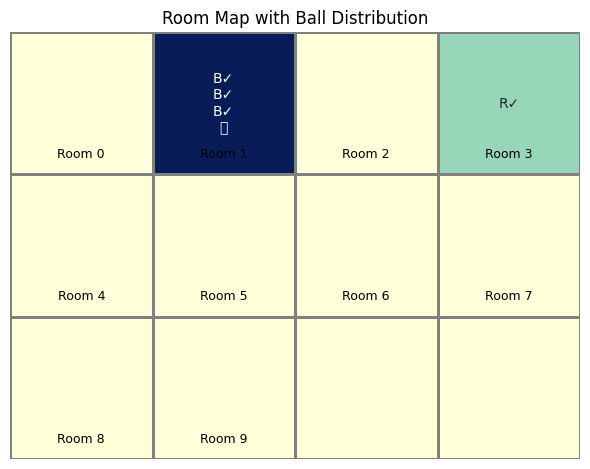

📌 Posterior belief: μ = 2.58, σ = 0.7500

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [0, 2] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


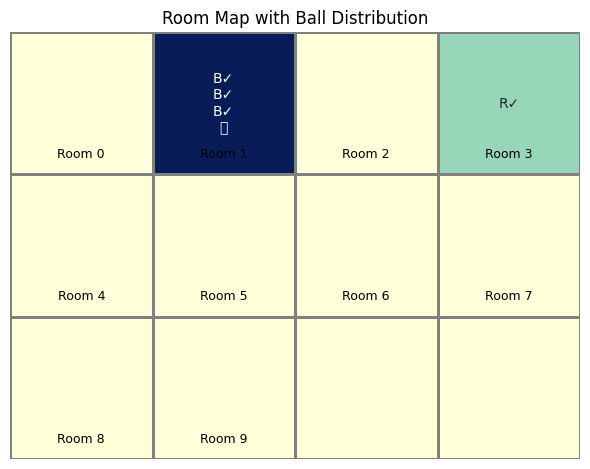

📌 Posterior belief: μ = 2.99, σ = 0.5669

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 2] | Empty: [2] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


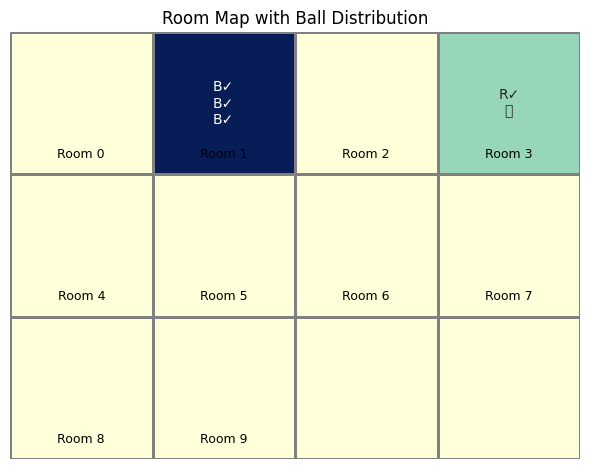

📌 Posterior belief: μ = 3.21, σ = 0.4523

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 7] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 7] | Empty: [0, 7] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


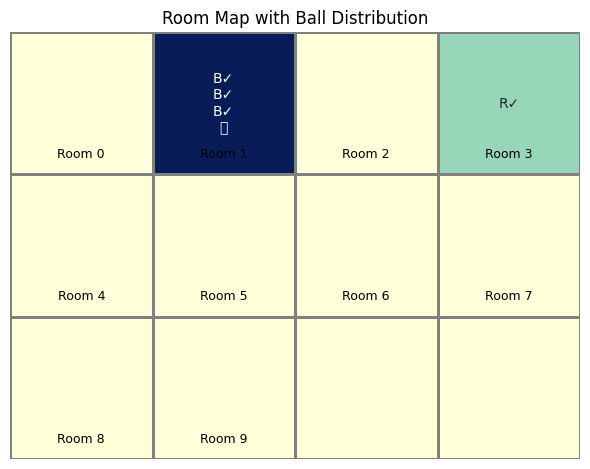

📌 Posterior belief: μ = 3.33, σ = 0.3750

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 2 — Moved from Room 6 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 6] | Empty: [2, 6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


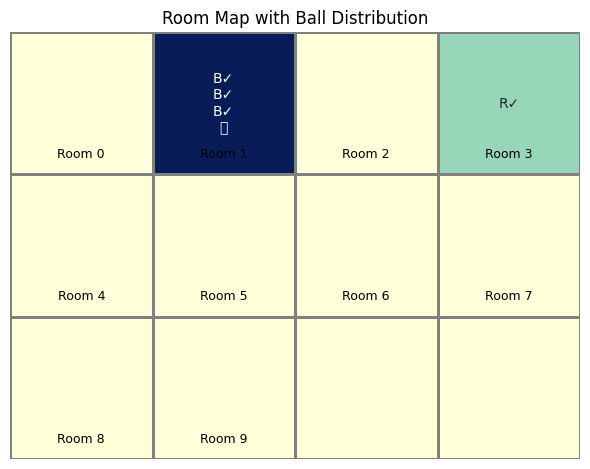

📌 Posterior belief: μ = 3.40, σ = 0.3198

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 2 — Moved from Room 6 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 6] | Empty: [6, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


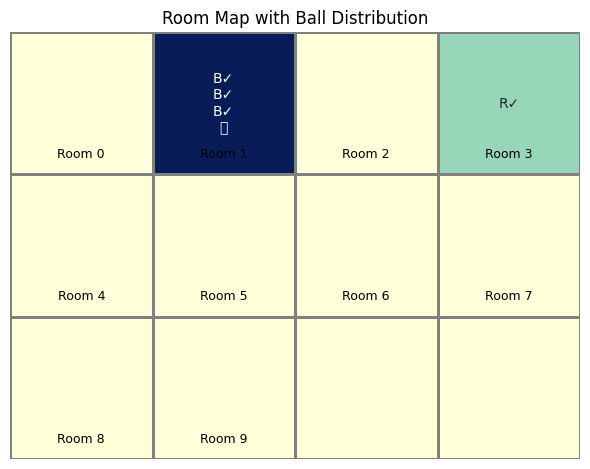

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


📌 Posterior belief: μ = 3.44, σ = 0.2785

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 2 — Moved from Room 5 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 5] | Empty: [0, 5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 5] | Empty: [0, 5] | M

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


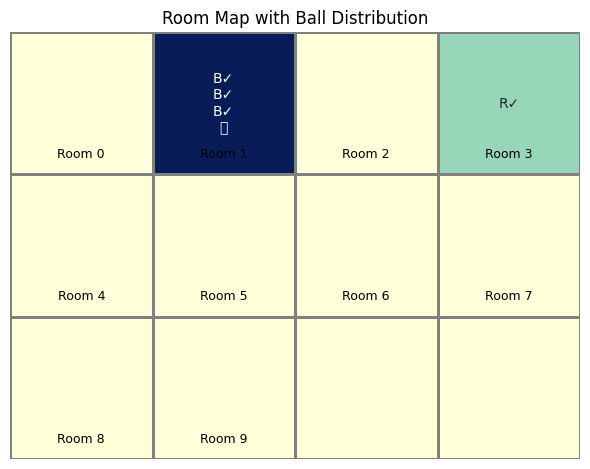

📌 Posterior belief: μ = 3.46, σ = 0.2466

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


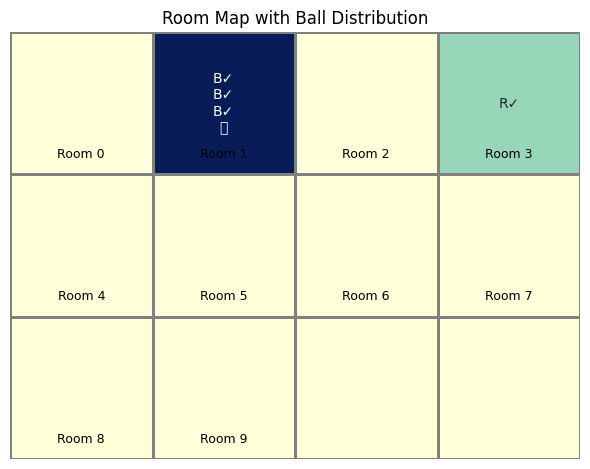

📌 Posterior belief: μ = 3.47, σ = 0.2212

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 2 — Moved from Room 5 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 5] | Empty: [5, 7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 3 — Moved from Room 7 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


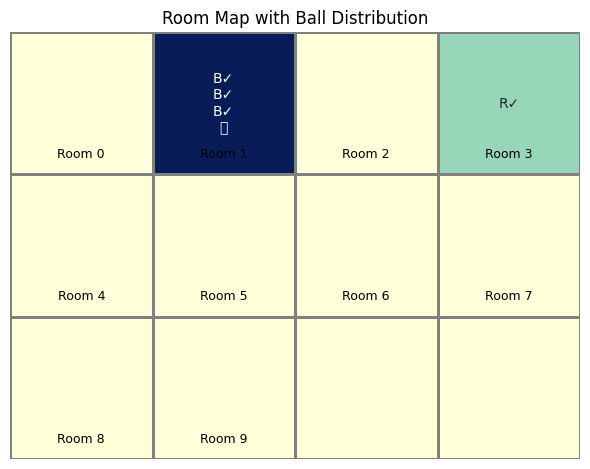

📌 Posterior belief: μ = 3.48, σ = 0.2004

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 7] | Empty: [5, 7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 3 — Moved from Room 5 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


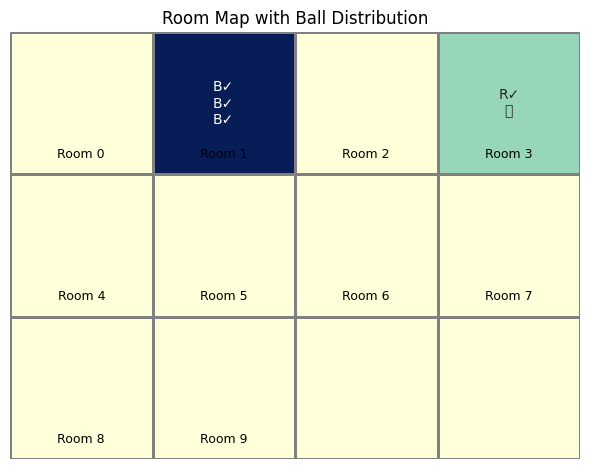

📌 Posterior belief: μ = 3.48, σ = 0.1833

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


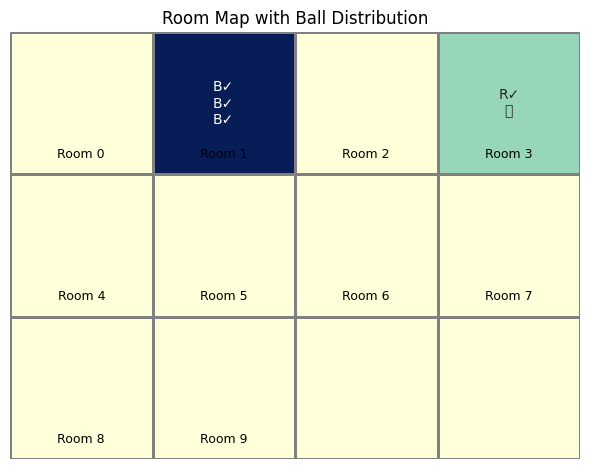

📌 Posterior belief: μ = 3.48, σ = 0.1688

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 7] | Empty: [7, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 3 — Moved from Room 8 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 7, 8] | Empty: 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


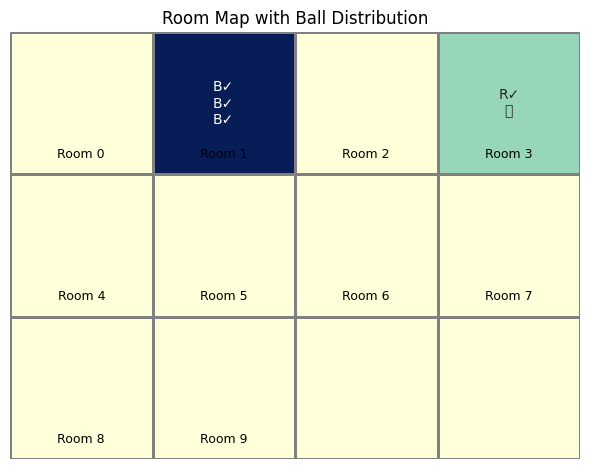

📌 Posterior belief: μ = 3.49, σ = 0.1564

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 2 — Moved from Room 8 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 8] | Empty: [6, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 3 — Moved from Room 6 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 6, 8] | Empty: [6, 8]

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


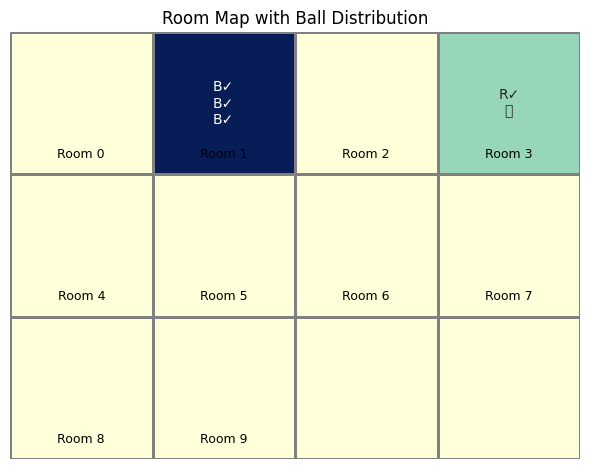

📌 Posterior belief: μ = 3.49, σ = 0.1457

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 7] | Empty: [2, 7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


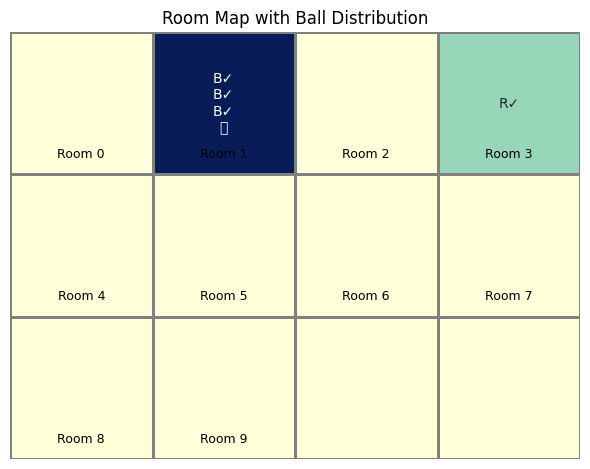

📌 Posterior belief: μ = 3.49, σ = 0.1364

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 4] | Empty: [4] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


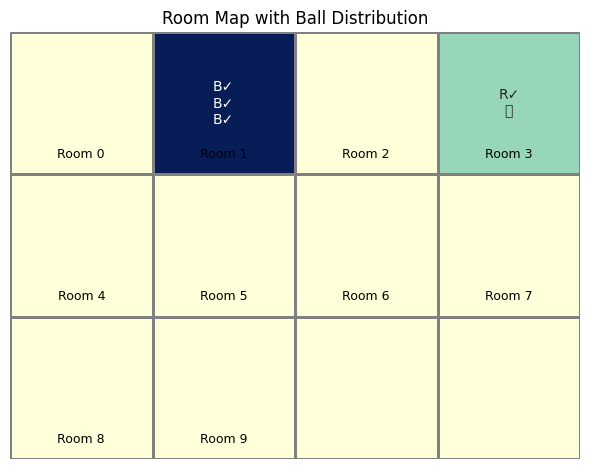

📌 Posterior belief: μ = 3.49, σ = 0.1282

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 2 — Moved from Room 5 → Room 3
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 5] | Empty: [5] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible RED ball in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 5] | Empty: [5] | Memory(Blue): []
------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


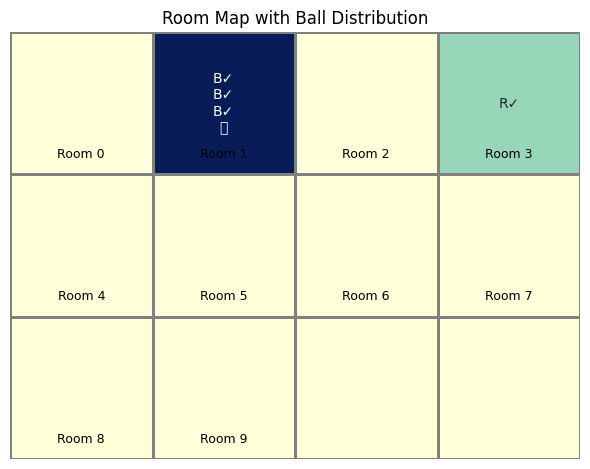

📌 Posterior belief: μ = 3.49, σ = 0.1209

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [0, 2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


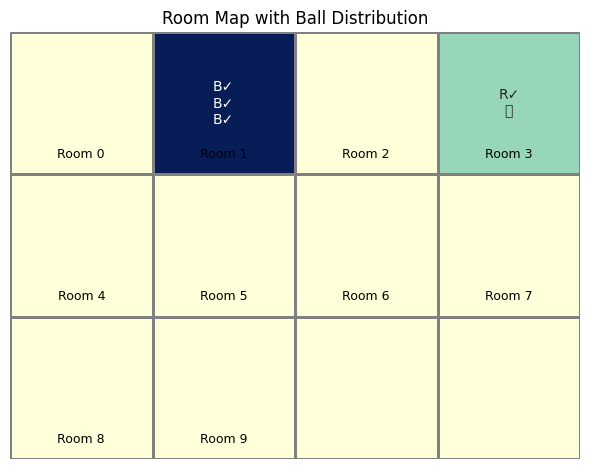

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


📌 Posterior belief: μ = 3.49, σ = 0.1144

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 2 — Moved from Room 9 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 9] | Empty: [4, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4, 9] | Empty: [4, 9] 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


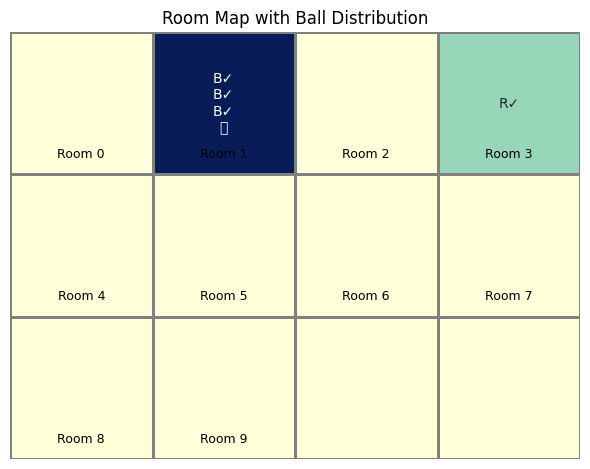

📌 Posterior belief: μ = 3.49, σ = 0.1085

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 2 — Moved from Room 5 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 5] | Empty: [0, 5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


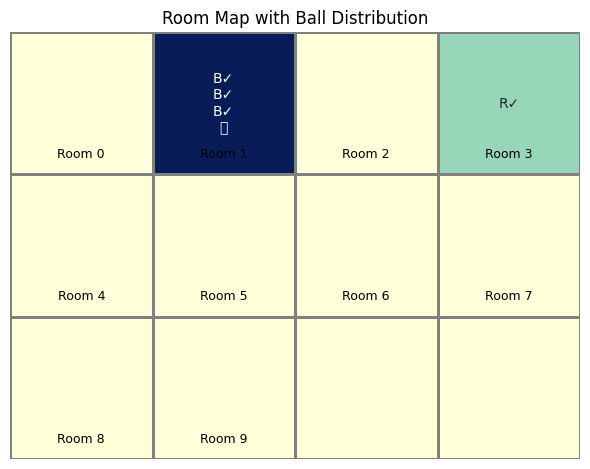

📌 Posterior belief: μ = 3.49, σ = 0.1033

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible RED ball in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [7] | Memory(Blue): []
------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


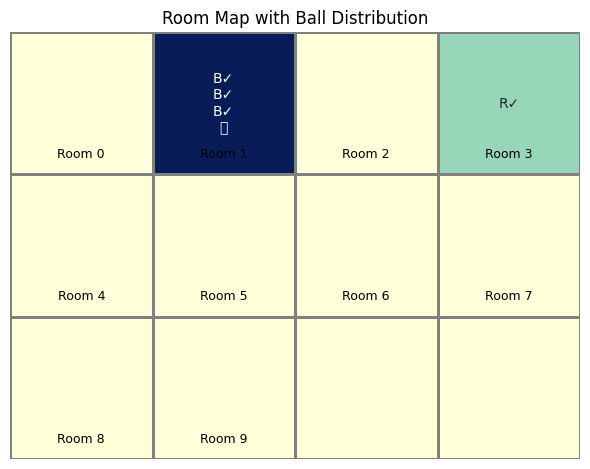

📌 Posterior belief: μ = 3.49, σ = 0.0985

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 2 — Moved from Room 9 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 9] | Empty: [6, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 3 — Moved from Room 6 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


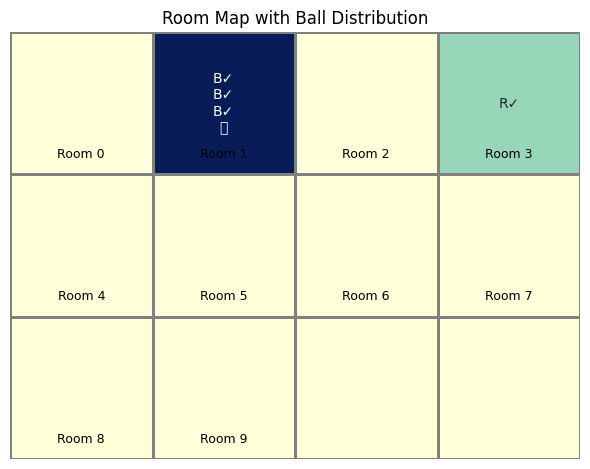

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


📌 Posterior belief: μ = 3.49, σ = 0.0941

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 7] | Empty: [7, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


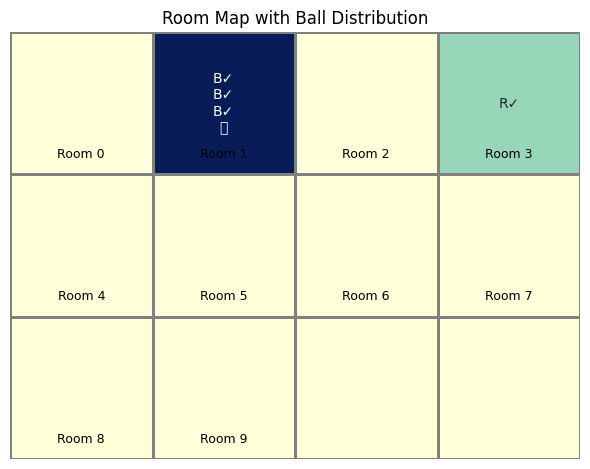

📌 Posterior belief: μ = 3.49, σ = 0.0901

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0] | Memory(Blue): []
-----------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


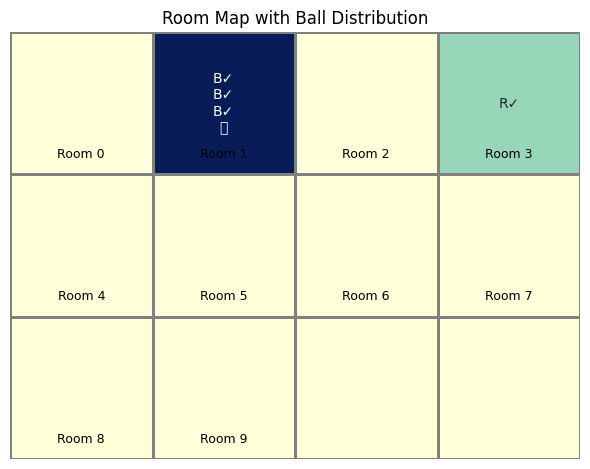

📌 Posterior belief: μ = 3.49, σ = 0.0865

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
--------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


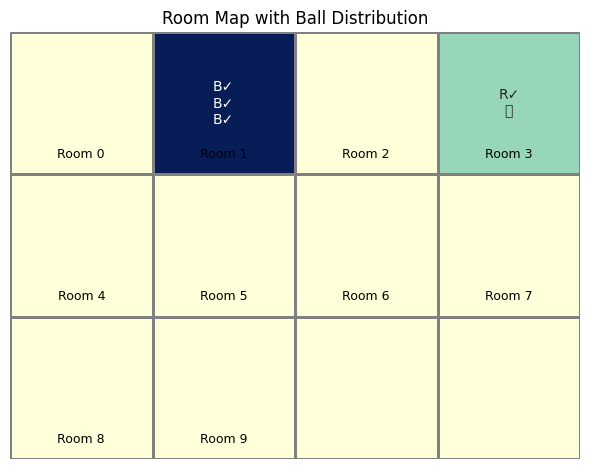

📌 Posterior belief: μ = 3.50, σ = 0.0831

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


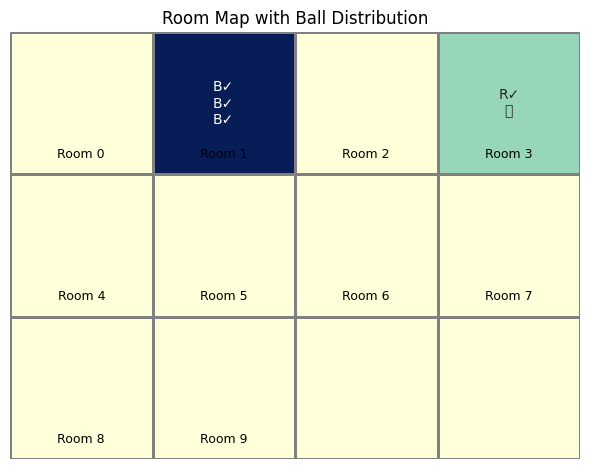

📌 Posterior belief: μ = 3.50, σ = 0.0800

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
--------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


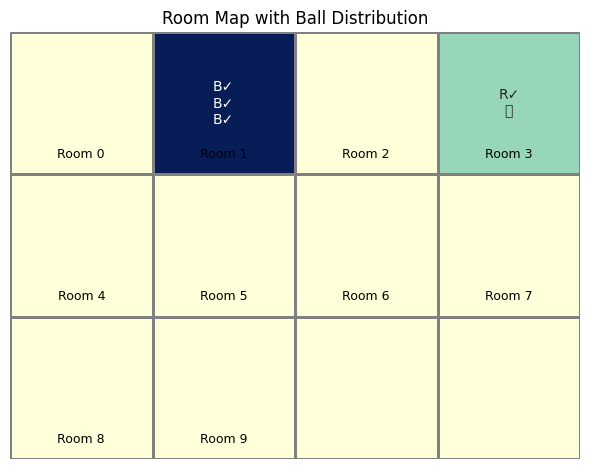

📌 Posterior belief: μ = 3.50, σ = 0.0770

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 2 — Moved from Room 6 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 6] | Empty: [2, 6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


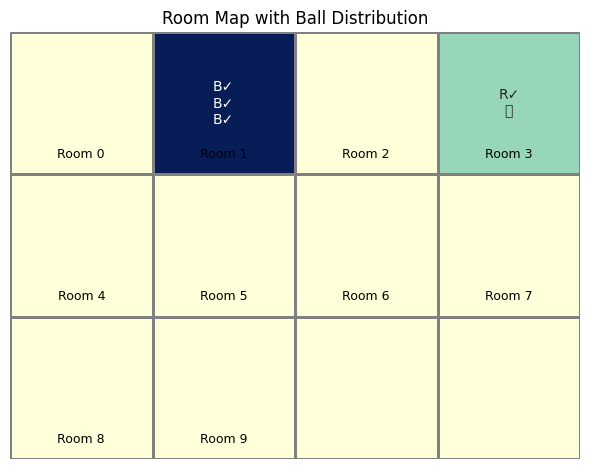

📌 Posterior belief: μ = 3.50, σ = 0.0744

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


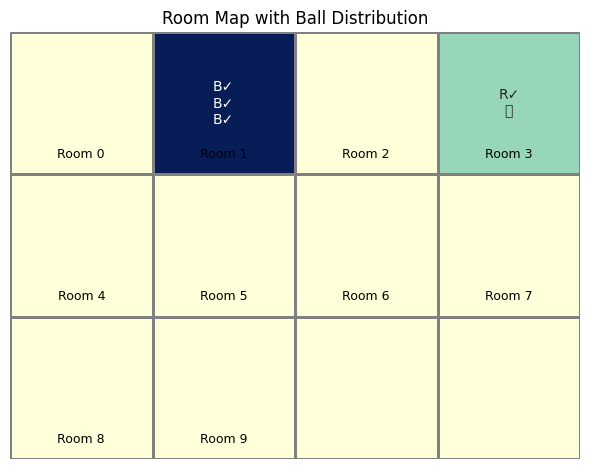

📌 Posterior belief: μ = 3.50, σ = 0.0718

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 3 — Moved from Room 7 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


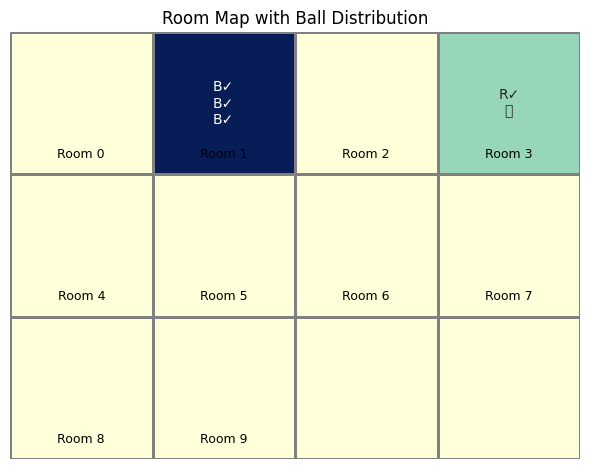

📌 Posterior belief: μ = 3.50, σ = 0.0695

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 2 — Moved from Room 5 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 5] | Empty: [0, 5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


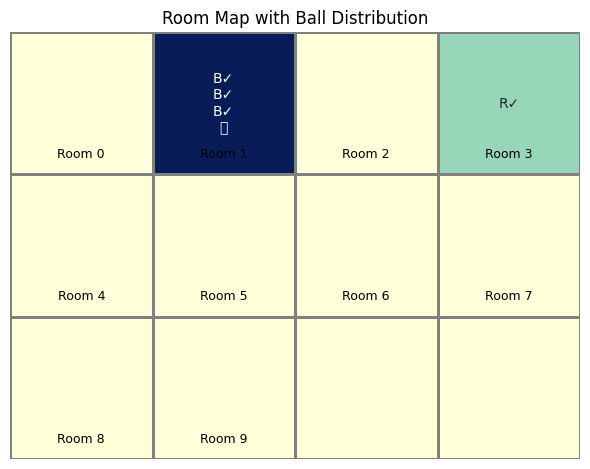

📌 Posterior belief: μ = 3.50, σ = 0.0673

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 3 — Moved from Room 6 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


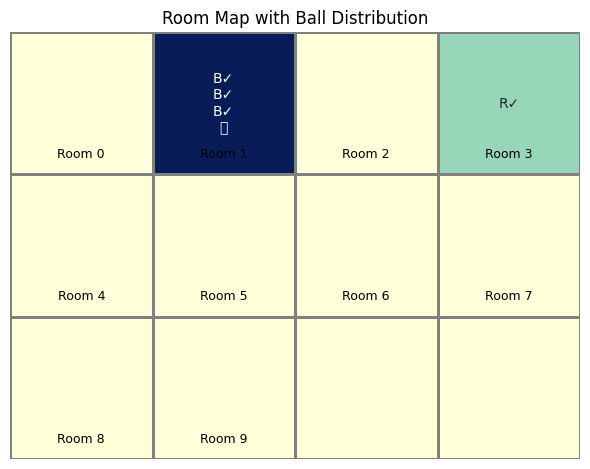

📌 Posterior belief: μ = 3.50, σ = 0.0652

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


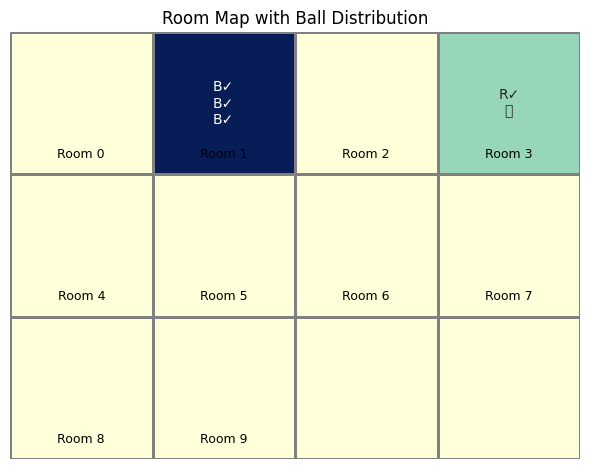

📌 Posterior belief: μ = 3.50, σ = 0.0633

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 3 — Moved from Room 5 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4, 5] | Empty: [4, 5] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


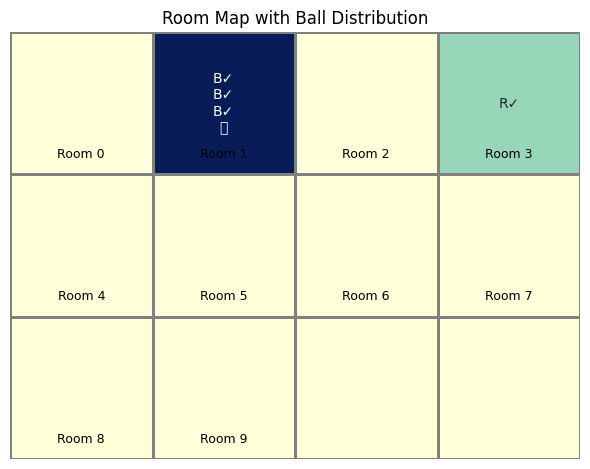

📌 Posterior belief: μ = 3.50, σ = 0.0614

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 3 — Moved from Room 6 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 6] | Empty: [6, 7] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


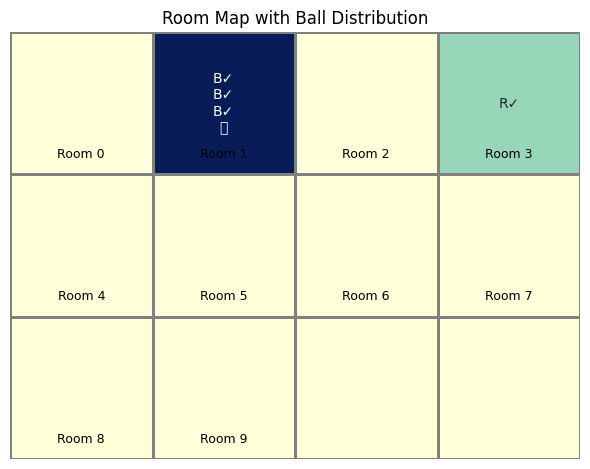

📌 Posterior belief: μ = 3.50, σ = 0.0597

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 2 — Moved from Room 8 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 8] | Empty: [4, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


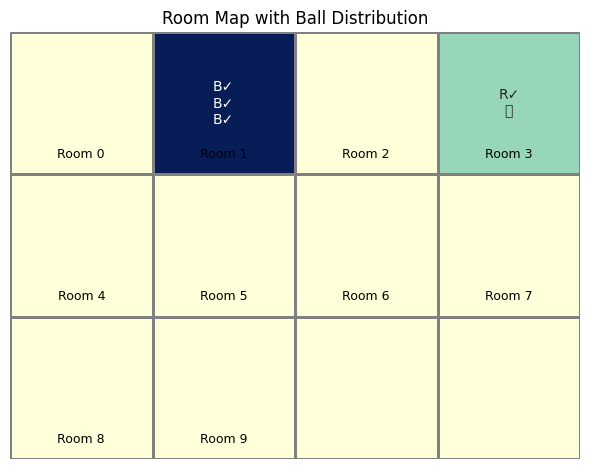

📌 Posterior belief: μ = 3.50, σ = 0.0581

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0, 8] | Memory(

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


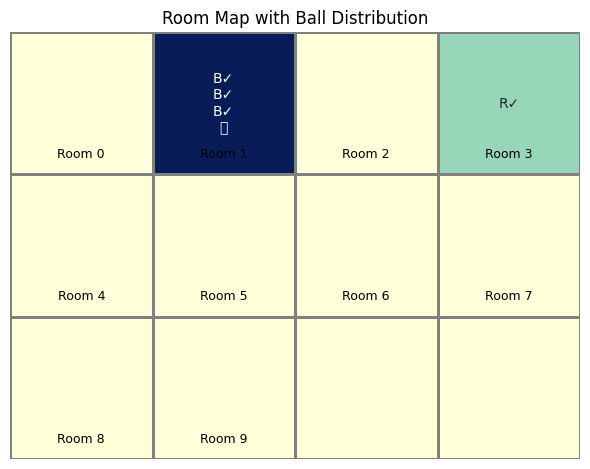

📌 Posterior belief: μ = 3.50, σ = 0.0565

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 3 — Moved from Room 5 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 5] | Empty: [5, 7] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


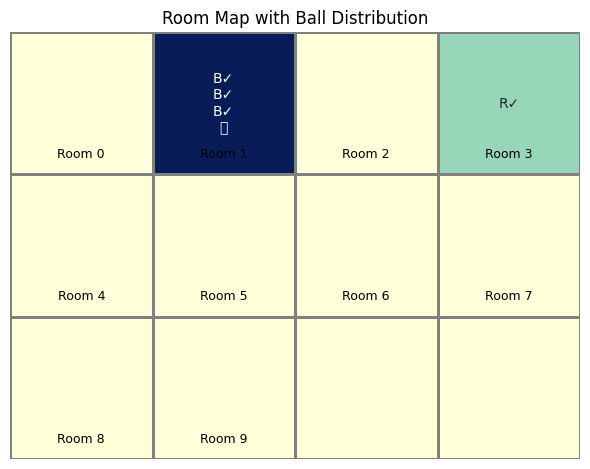

📌 Posterior belief: μ = 3.50, σ = 0.0551

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


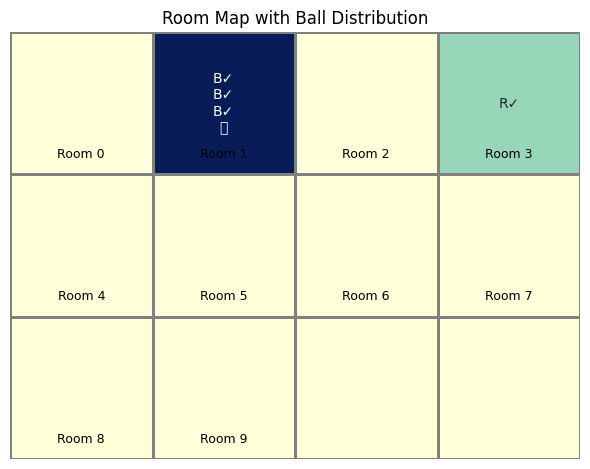

📌 Posterior belief: μ = 3.49, σ = 0.0537

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 2 — Moved from Room 9 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 9] | Empty: [6, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 3 — Moved from Room 6 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 6, 9] | Empty: [6, 9]

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


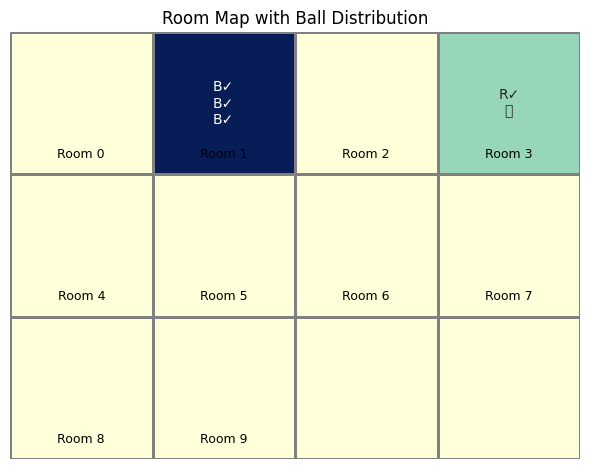

📌 Posterior belief: μ = 3.49, σ = 0.0524

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


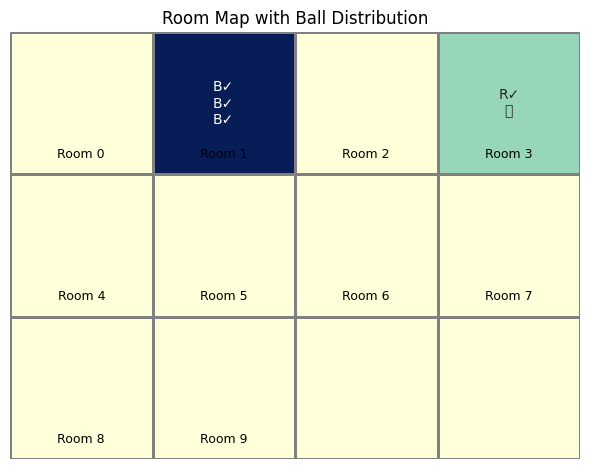

📌 Posterior belief: μ = 3.49, σ = 0.0511

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 7] | Empty: [6, 7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 3 — Moved from Room 6 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


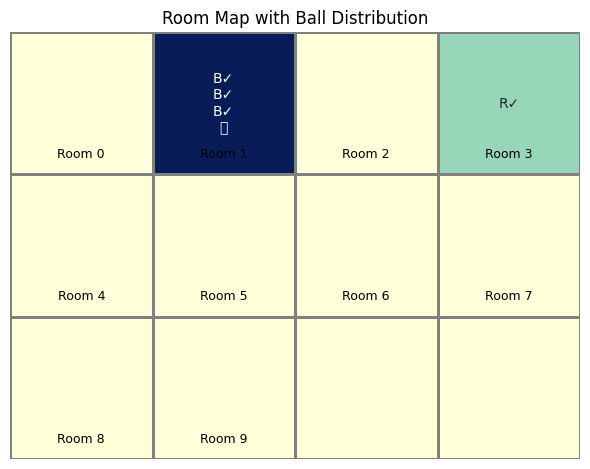

📌 Posterior belief: μ = 3.49, σ = 0.0499

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 2 — Moved from Room 6 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 6] | Empty: [0, 6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 6] | Empty: [0, 6] | 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


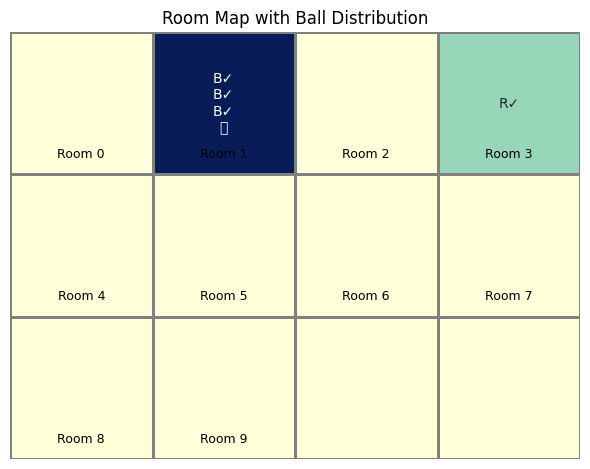

📌 Posterior belief: μ = 3.49, σ = 0.0487

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 3
   😐 No new balls found in this room
   🧱 Marking Room 3 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2, 3] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


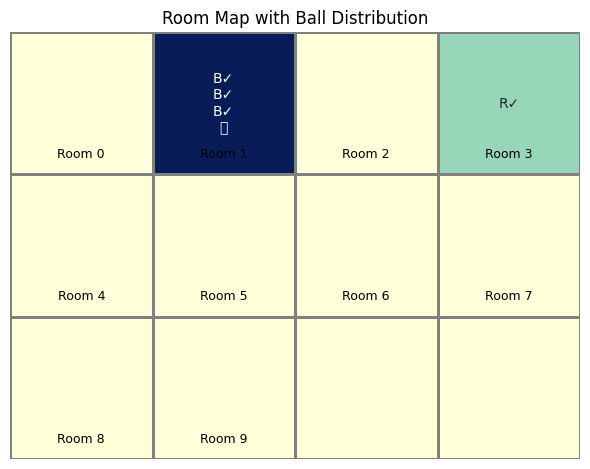

📌 Posterior belief: μ = 3.49, σ = 0.0476

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 2 — Moved from Room 9 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 9] | Empty: [4, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


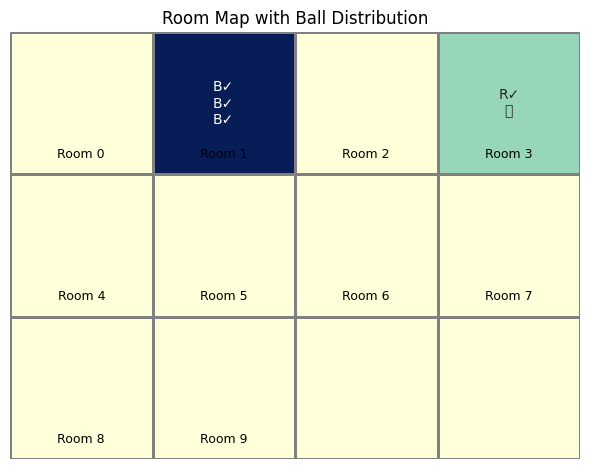

📌 Posterior belief: μ = 3.49, σ = 0.0466

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 2 — Moved from Room 6 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 6] | Empty: [6, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


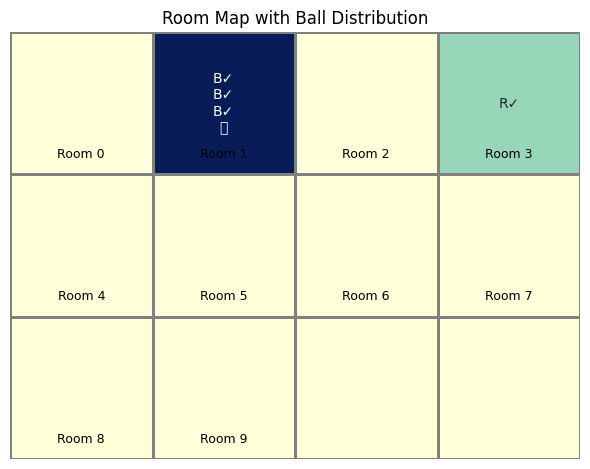

📌 Posterior belief: μ = 3.49, σ = 0.0456

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4, 9] | Empty: [4, 9] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


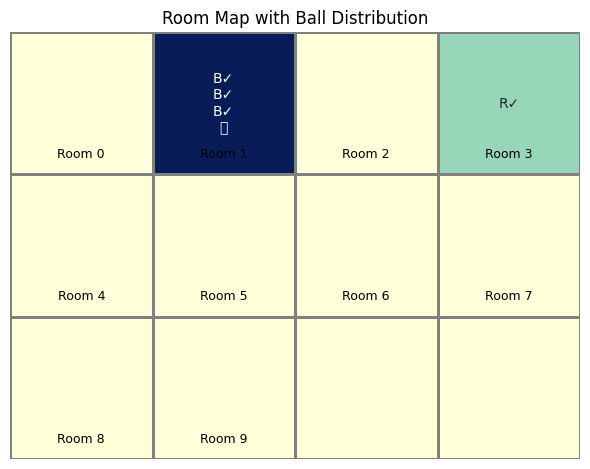

📌 Posterior belief: μ = 3.49, σ = 0.0446

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 2 — Moved from Room 5 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 5] | Empty: [4, 5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4, 5] | Empty: [4, 5] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


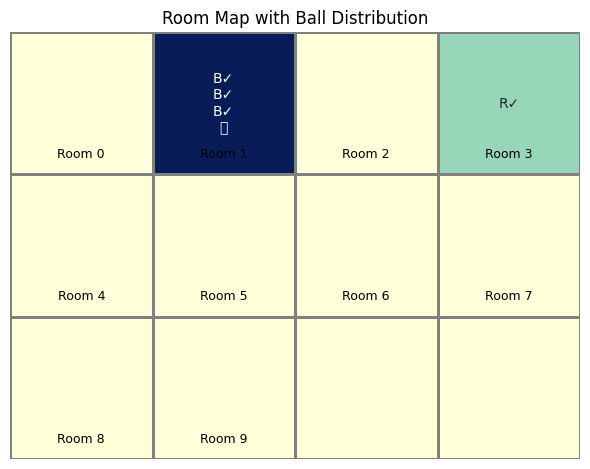

📌 Posterior belief: μ = 3.49, σ = 0.0437

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 3 — Moved from Room 8 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4, 8] | Empty: [4, 8]

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


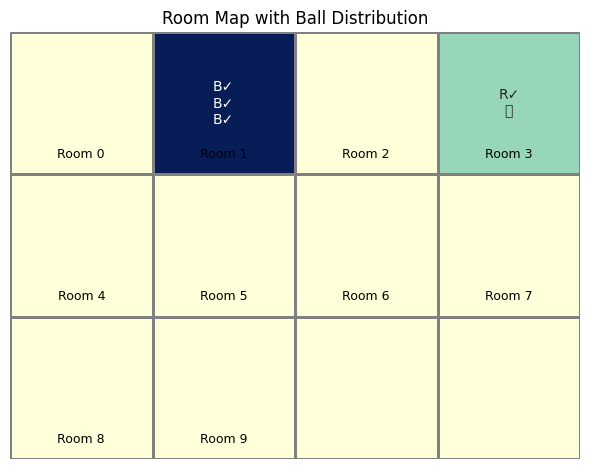

📌 Posterior belief: μ = 3.49, σ = 0.0428

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 3 — Moved from Room 7 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


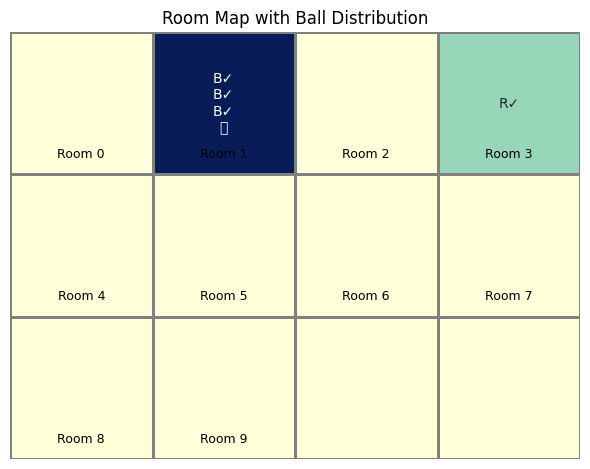

📌 Posterior belief: μ = 3.49, σ = 0.0420

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


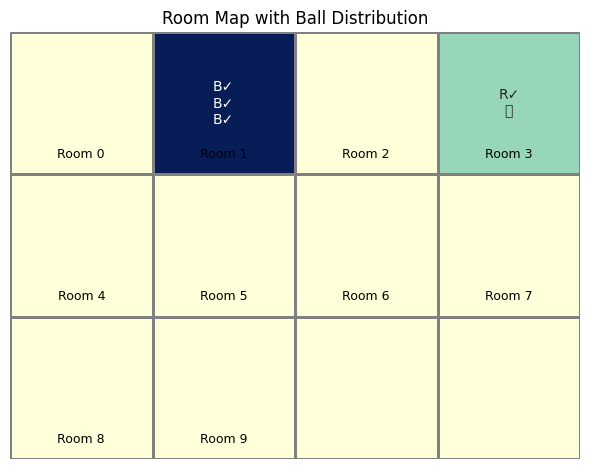

📌 Posterior belief: μ = 3.49, σ = 0.0412

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 2 — Moved from Room 5 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 5] | Empty: [2, 5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 5] | Empty: [2, 5] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


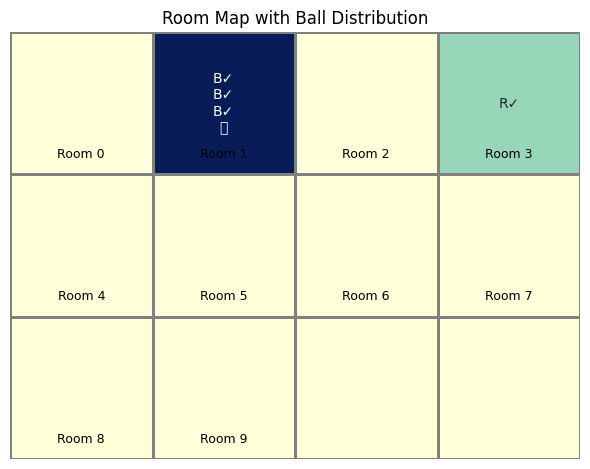

📌 Posterior belief: μ = 3.49, σ = 0.0404

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2] | Memory(Blue): [1]
----------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


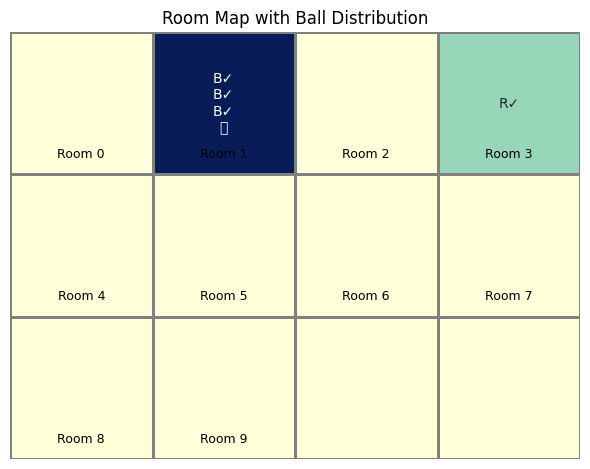

📌 Posterior belief: μ = 3.49, σ = 0.0396

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 2 — Moved from Room 5 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 5] | Empty: [5, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 3 — Moved from Room 8 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


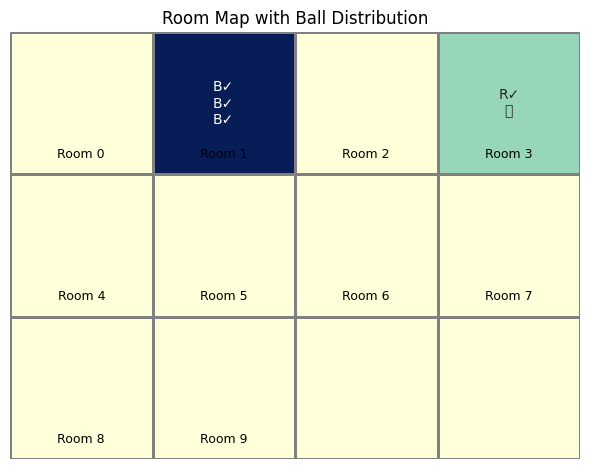

📌 Posterior belief: μ = 3.49, σ = 0.0389

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 7] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 7] | Empty: [6, 7] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


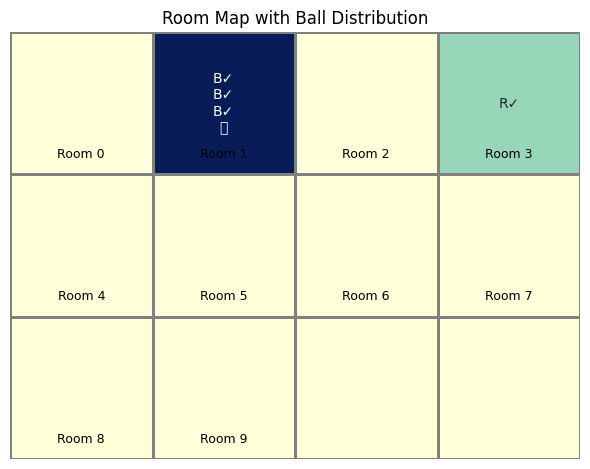

📌 Posterior belief: μ = 3.49, σ = 0.0382

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 9] | Empty: [7, 9] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


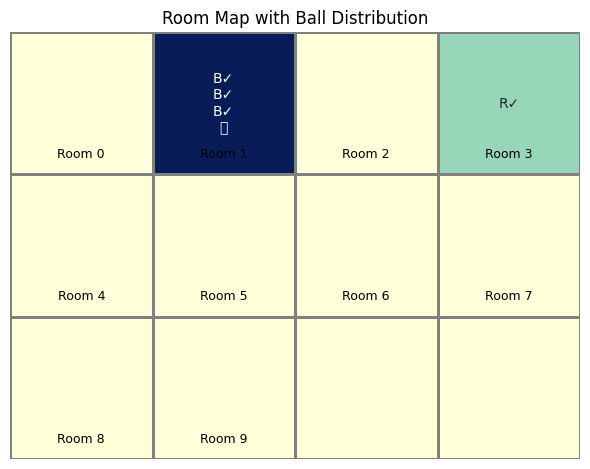

📌 Posterior belief: μ = 3.49, σ = 0.0375

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 7] | Empty: [5, 7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 3 — Moved from Room 5 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


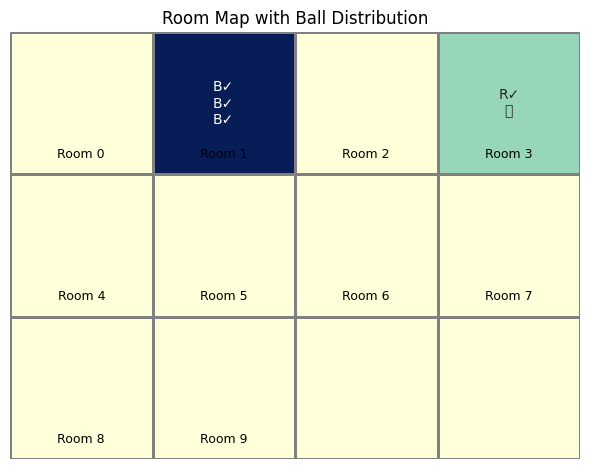

📌 Posterior belief: μ = 3.49, σ = 0.0369

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


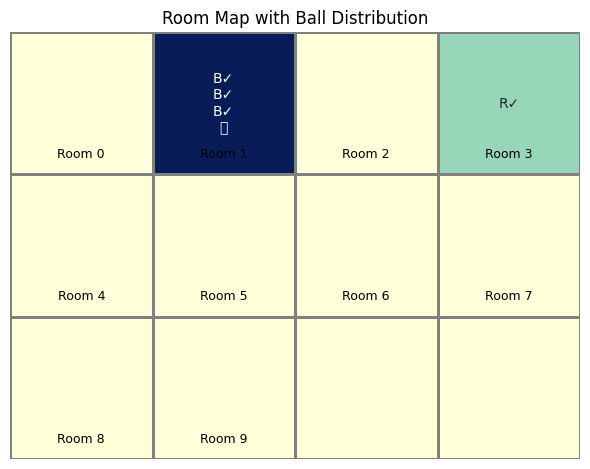

📌 Posterior belief: μ = 3.49, σ = 0.0363

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 2 — Moved from Room 8 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 8] | Empty: [8] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 8] | Empty: [8] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


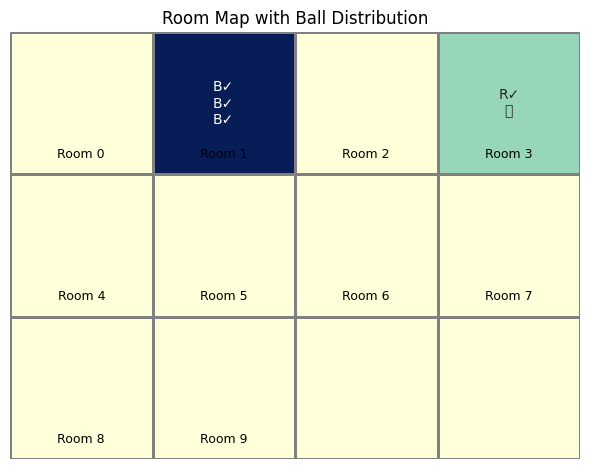

📌 Posterior belief: μ = 3.49, σ = 0.0356

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 2 — Moved from Room 8 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 8] | Empty: [4, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


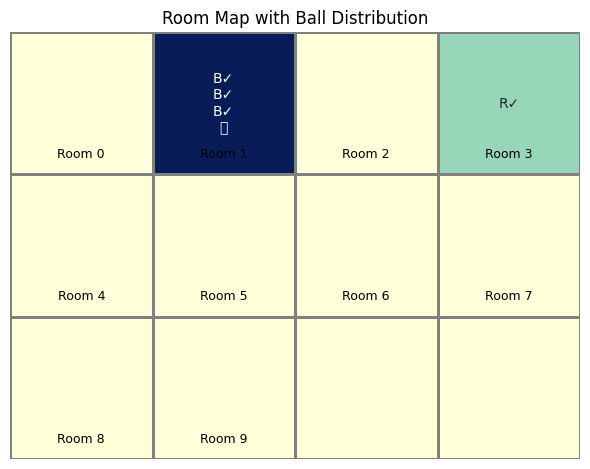

📌 Posterior belief: μ = 3.49, σ = 0.0351

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 2 — Moved from Room 8 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 8] | Empty: [6, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 3 — Moved from Room 6 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


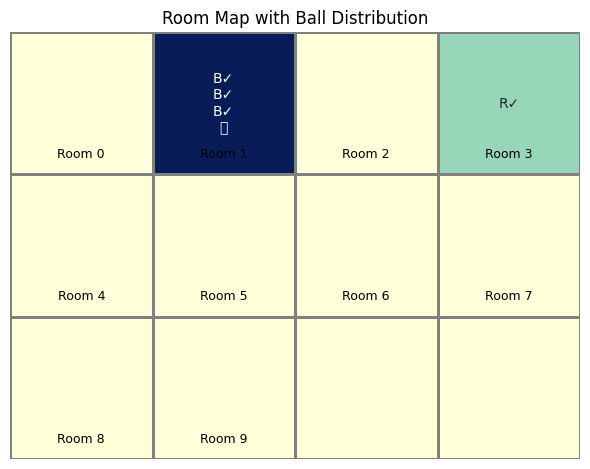

📌 Posterior belief: μ = 3.49, σ = 0.0345

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 4] | Empty: [2, 4]

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


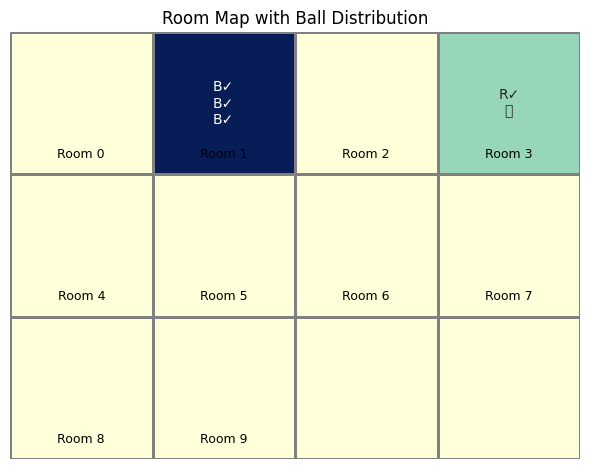

📌 Posterior belief: μ = 3.49, σ = 0.0339

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 2 — Moved from Room 9 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 9] | Empty: [4, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


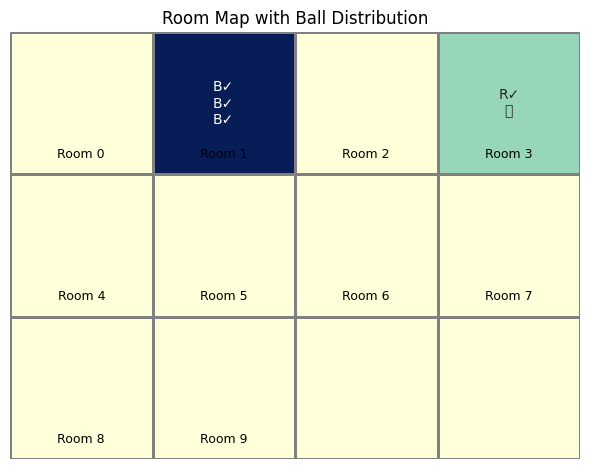

📌 Posterior belief: μ = 3.49, σ = 0.0334

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


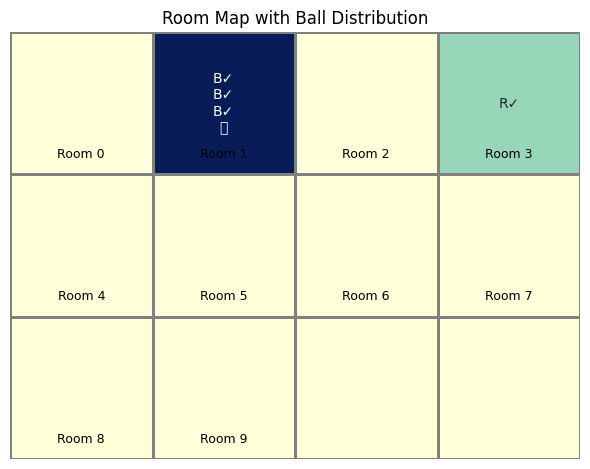

📌 Posterior belief: μ = 3.49, σ = 0.0329

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


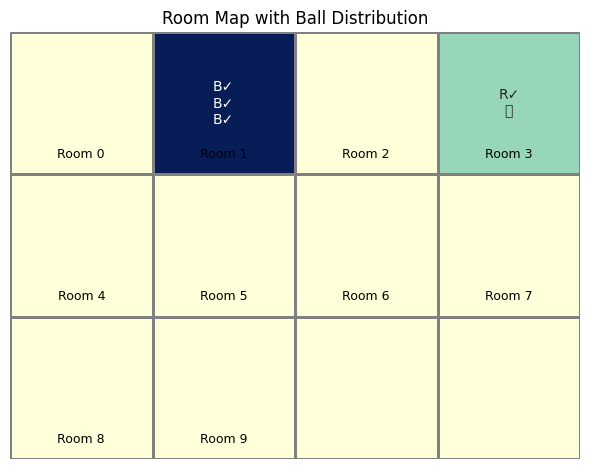

📌 Posterior belief: μ = 3.49, σ = 0.0324

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 4] | Empty: [2, 4] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


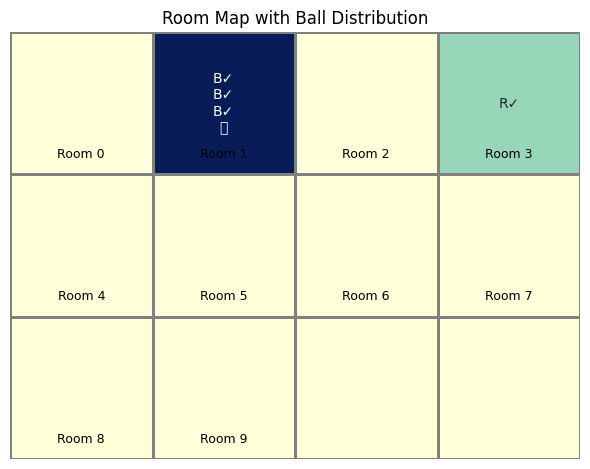

📌 Posterior belief: μ = 3.49, σ = 0.0319

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


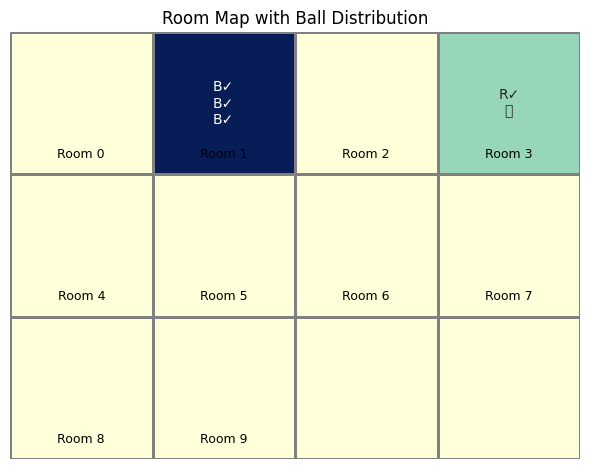

📌 Posterior belief: μ = 3.49, σ = 0.0314

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 3 — Moved from Room 8 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


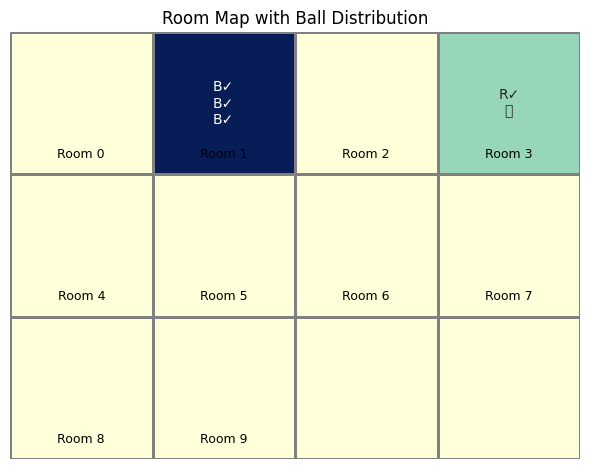

📌 Posterior belief: μ = 3.49, σ = 0.0310

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 7] | Empty: [7] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 7] | Empty: [7] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


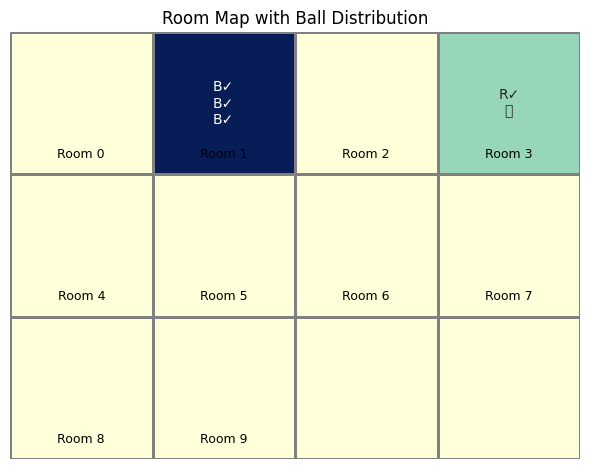

📌 Posterior belief: μ = 3.49, σ = 0.0305

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
--------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


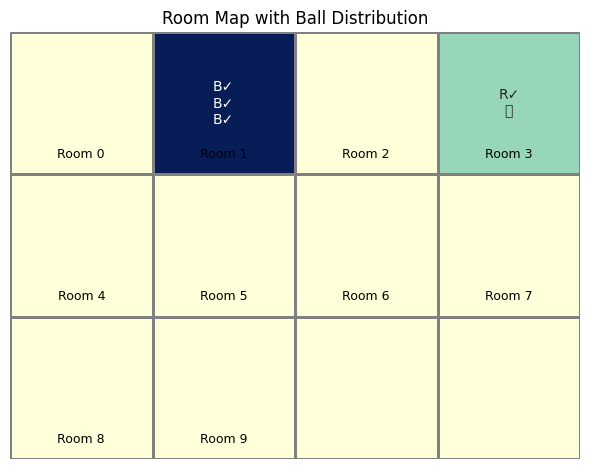

📌 Posterior belief: μ = 3.49, σ = 0.0301

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 2 — Moved from Room 6 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 6] | Empty: [5, 6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 3 — Moved from Room 5 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


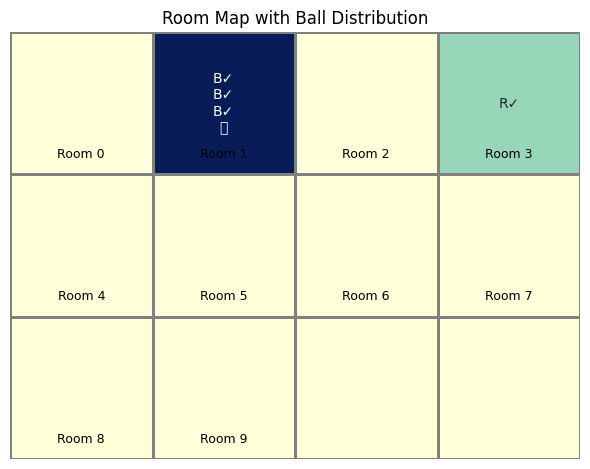

📌 Posterior belief: μ = 3.49, σ = 0.0297

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 3 — Moved from Room 8 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


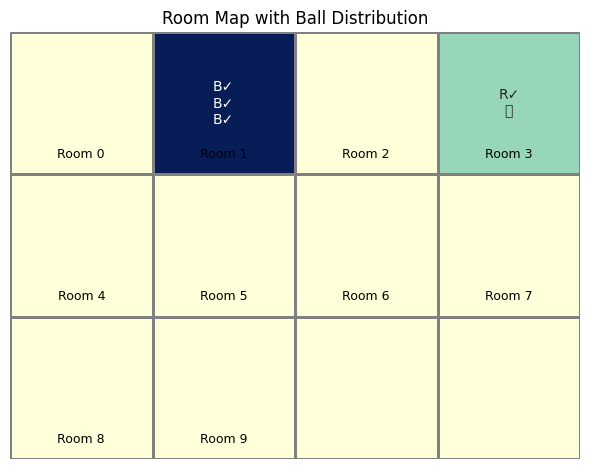

📌 Posterior belief: μ = 3.49, σ = 0.0293

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


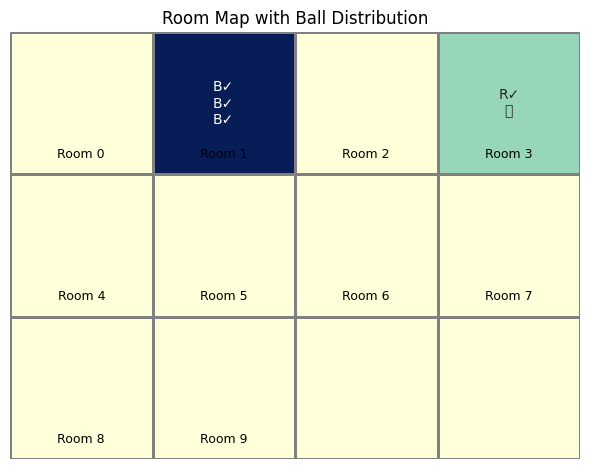

📌 Posterior belief: μ = 3.49, σ = 0.0289

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 2 — Moved from Room 9 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 9] | Empty: [2, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


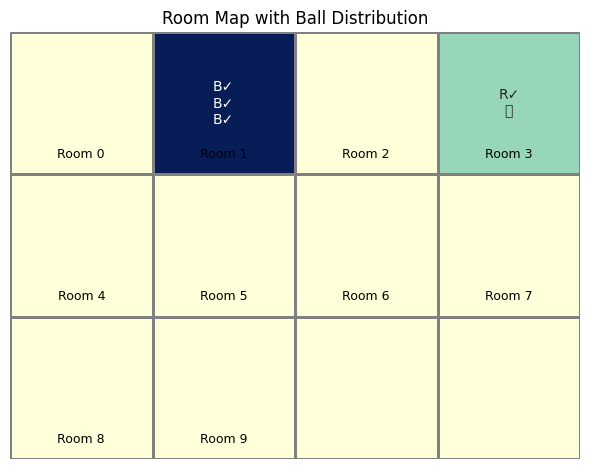

📌 Posterior belief: μ = 3.49, σ = 0.0285

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 2 — Moved from Room 8 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 8] | Empty: [5, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 3 — Moved from Room 5 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


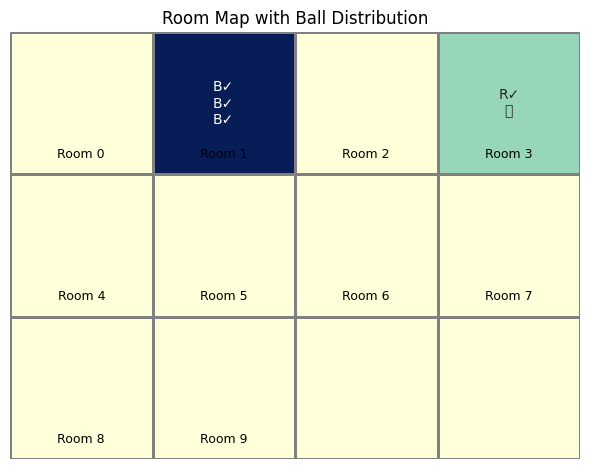

📌 Posterior belief: μ = 3.49, σ = 0.0281

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 2 — Moved from Room 9 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 9] | Empty: [9] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 9] | Empty: [9] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


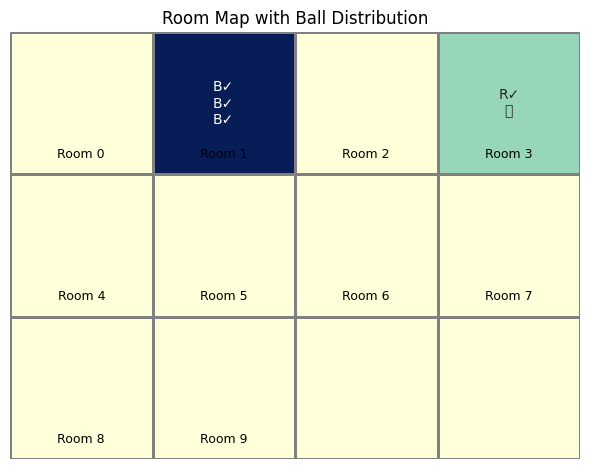

📌 Posterior belief: μ = 3.49, σ = 0.0277

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 2 — Moved from Room 6 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 6] | Empty: [5, 6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 3 — Moved from Room 5 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 5, 6] | Empty: [5, 6] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


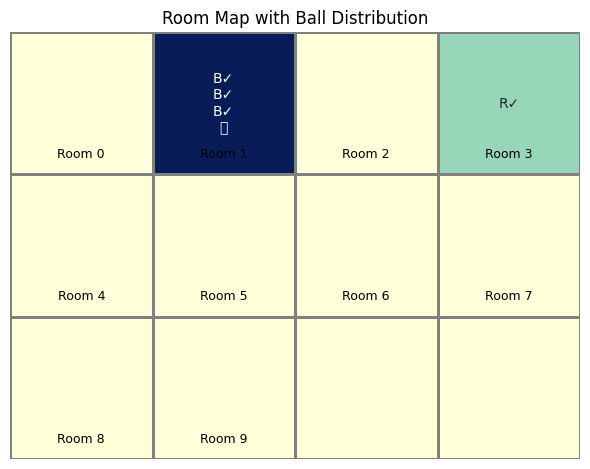

📌 Posterior belief: μ = 3.49, σ = 0.0274

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 3 — Moved from Room 8 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


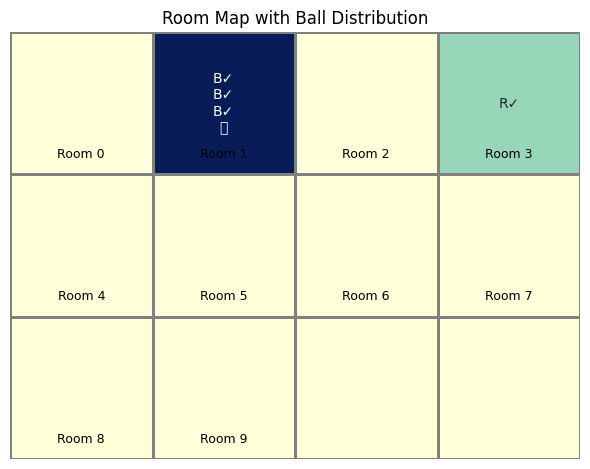

📌 Posterior belief: μ = 3.48, σ = 0.0270

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 2] | Empty: [2] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


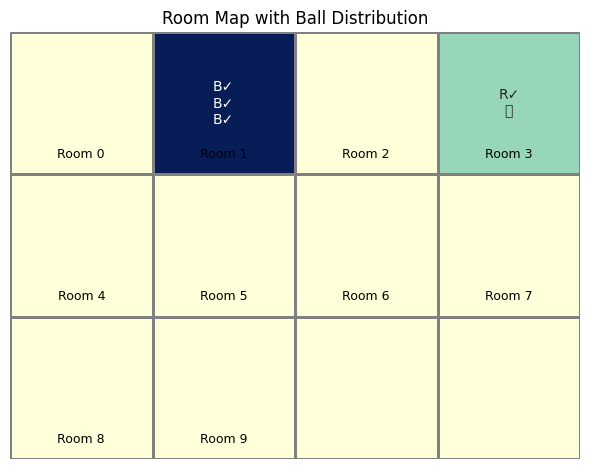

📌 Posterior belief: μ = 3.48, σ = 0.0267

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 7] | Empty: [7] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 7] | Empty: [7] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


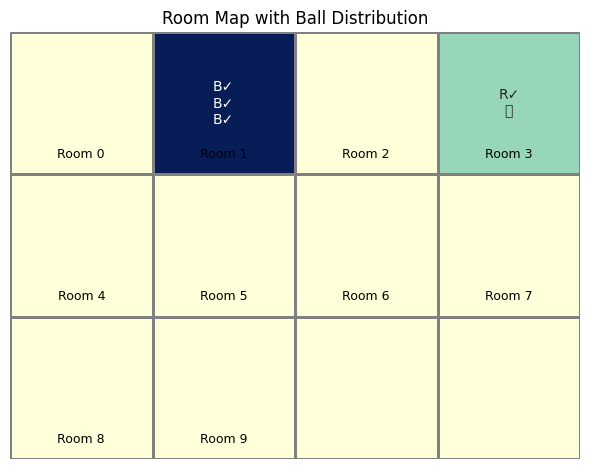

📌 Posterior belief: μ = 3.48, σ = 0.0263

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 2 — Moved from Room 9 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 9] | Empty: [8, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 3 — Moved from Room 8 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


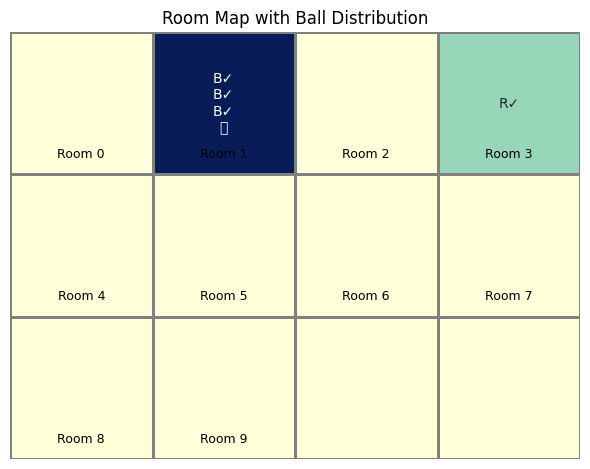

📌 Posterior belief: μ = 3.48, σ = 0.0260

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0, 2] | Memory(

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


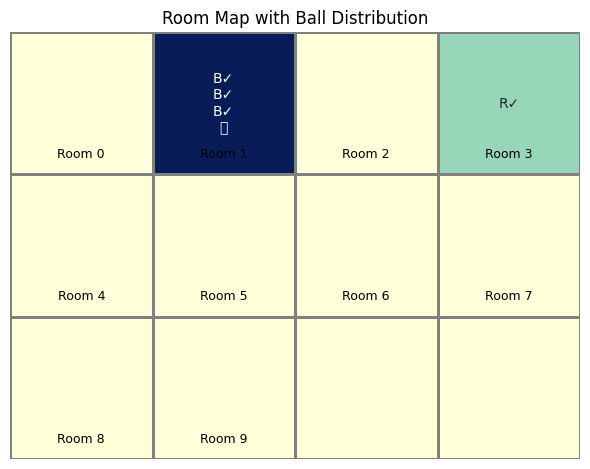

📌 Posterior belief: μ = 3.48, σ = 0.0257

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 7] | Empty: [2, 7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 7] | Empty: [2, 7]

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


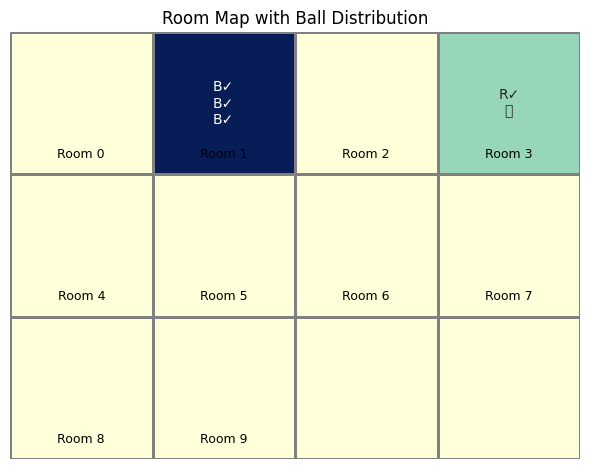

📌 Posterior belief: μ = 3.48, σ = 0.0254

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 4] | Empty: [0, 4] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


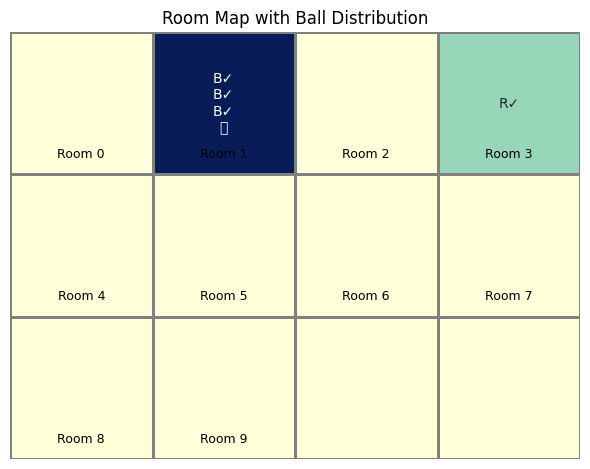

📌 Posterior belief: μ = 3.48, σ = 0.0251

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 3 — Moved from Room 8 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


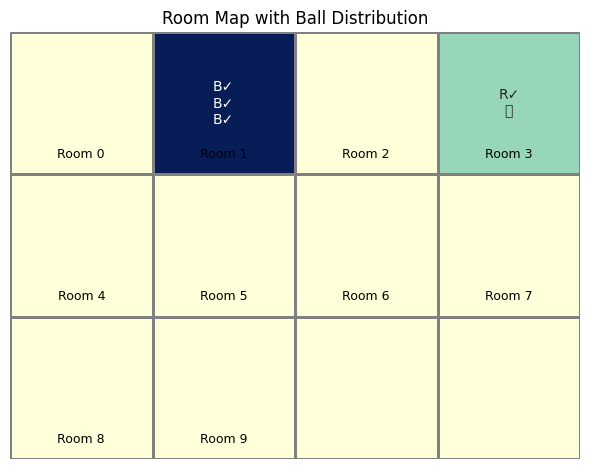

📌 Posterior belief: μ = 3.48, σ = 0.0248

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 9] | Empty: [7, 9] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


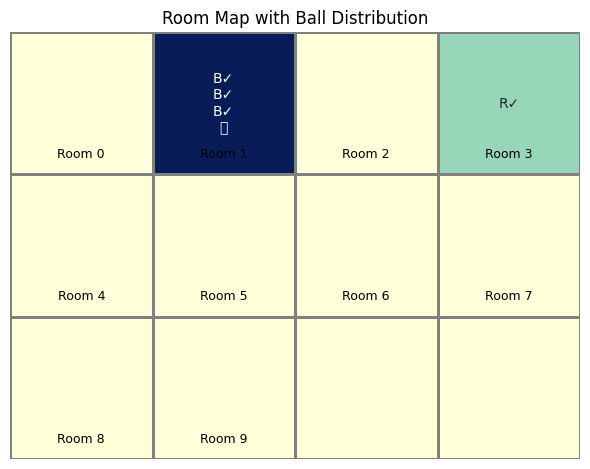

📌 Posterior belief: μ = 3.48, σ = 0.0245

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 8
🔄 STEP 2 — Moved from Room 8 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 8] | Empty: [6, 8] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 3 — Moved from Room 6 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


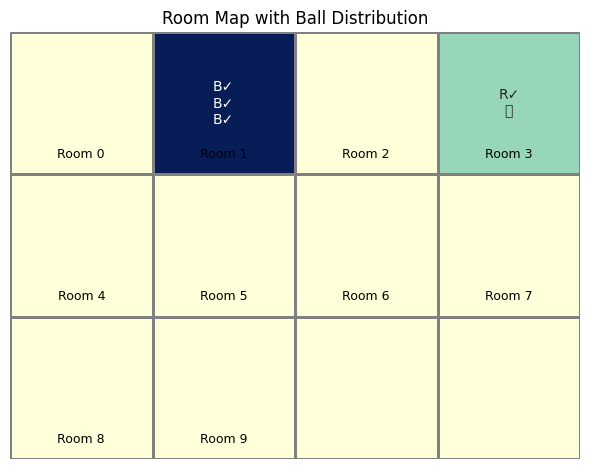

📌 Posterior belief: μ = 3.48, σ = 0.0242

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 2 — Moved from Room 6 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 6] | Empty: [0, 6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


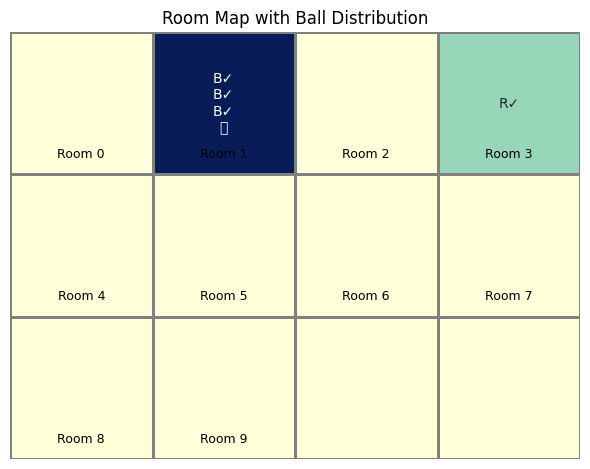

📌 Posterior belief: μ = 3.48, σ = 0.0240

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 5
   😐 No new balls found in this room
   🧱 Marking Room 5 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [5] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 5
🔄 STEP 3 — Moved from Room 5 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 5] | Empty: [5, 8] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


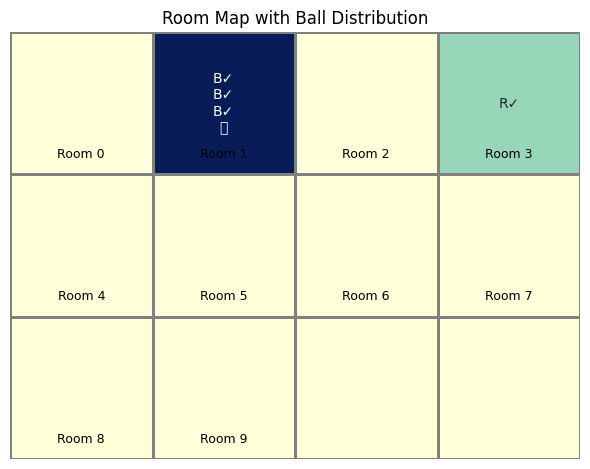

📌 Posterior belief: μ = 3.48, σ = 0.0237

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


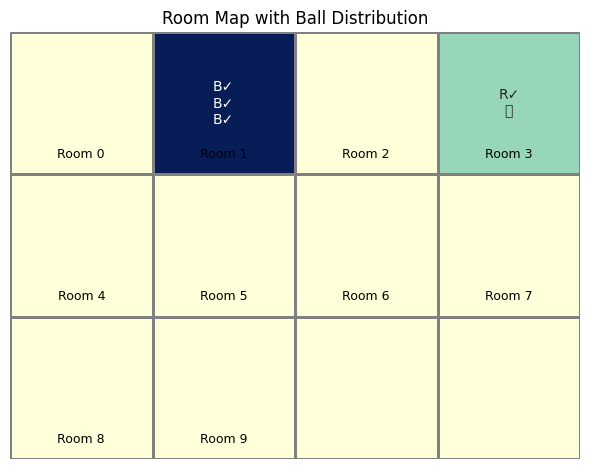

📌 Posterior belief: μ = 3.48, σ = 0.0234

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 4] | Empty: [4] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


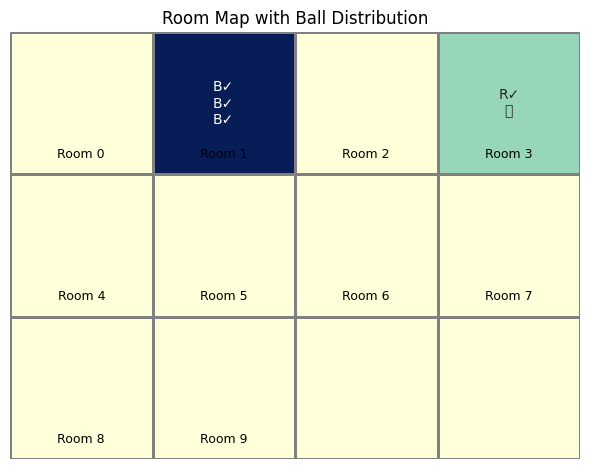

📌 Posterior belief: μ = 3.48, σ = 0.0232

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


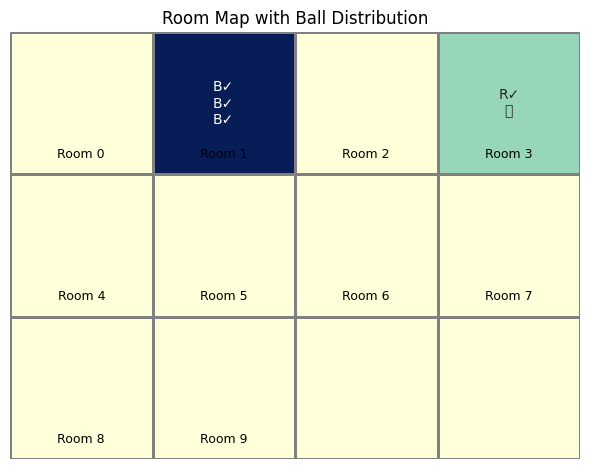

📌 Posterior belief: μ = 3.48, σ = 0.0229

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [0, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


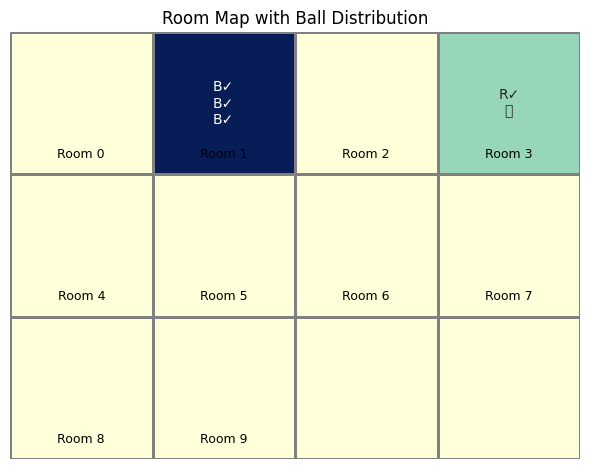

📌 Posterior belief: μ = 3.48, σ = 0.0227

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 2 — Moved from Room 7 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 7] | Empty: [7] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 7] | Empty: [7] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


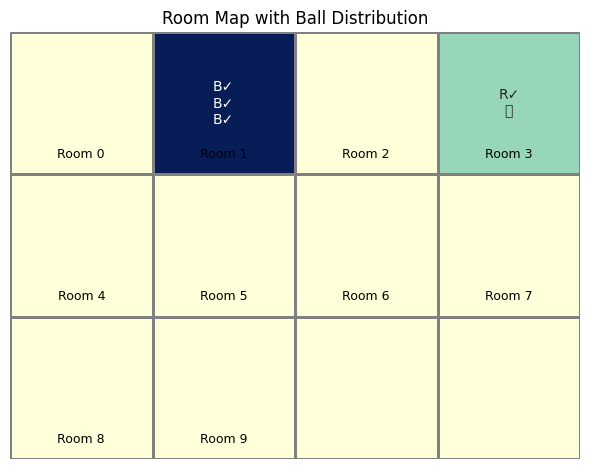

📌 Posterior belief: μ = 3.48, σ = 0.0224

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


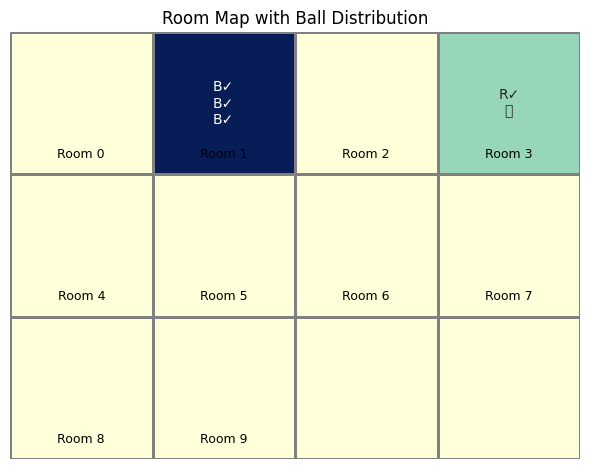

📌 Posterior belief: μ = 3.48, σ = 0.0222

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


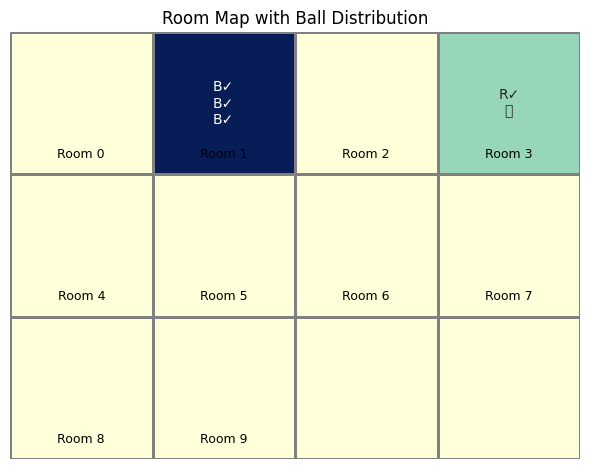

📌 Posterior belief: μ = 3.48, σ = 0.0220

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 3 — Moved from Room 9 → Room 8
   😐 No new balls found in this room
   🧱 Marking Room 8 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


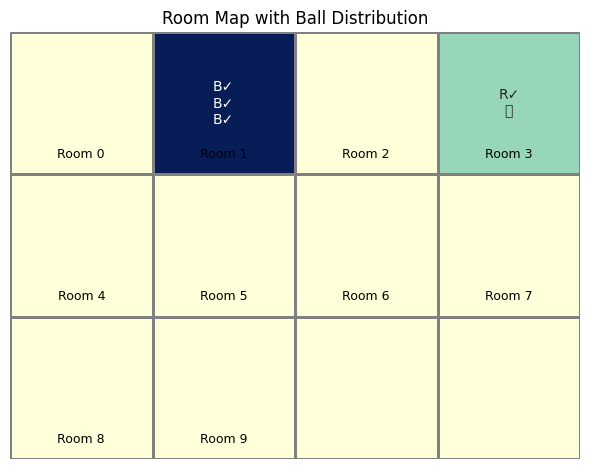

📌 Posterior belief: μ = 3.48, σ = 0.0218

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 6
   😐 No new balls found in this room
   🧱 Marking Room 6 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [6] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 6
🔄 STEP 2 — Moved from Room 6 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 6] | Empty: [6] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 6] | Empty: [6] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


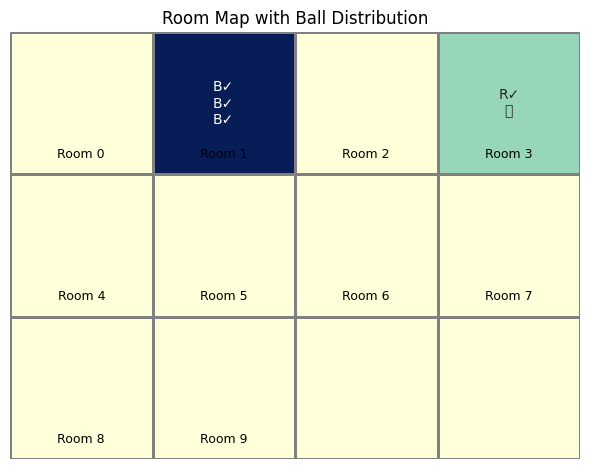

📌 Posterior belief: μ = 3.48, σ = 0.0215

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 7
   😐 No new balls found in this room
   🧱 Marking Room 7 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 7] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 7
🔄 STEP 3 — Moved from Room 7 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


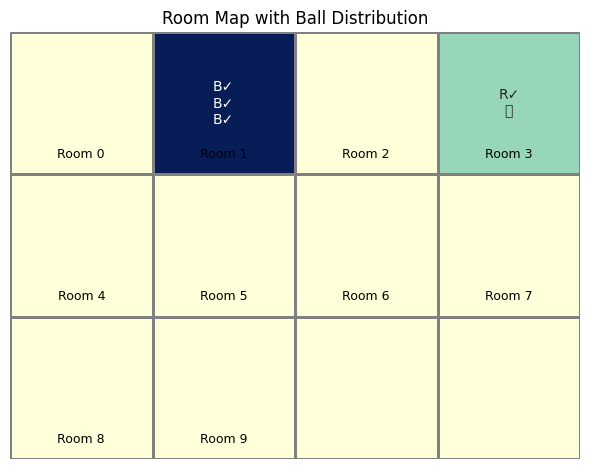

📌 Posterior belief: μ = 3.48, σ = 0.0213

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 9
   😐 No new balls found in this room
   🧱 Marking Room 9 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 9
🔄 STEP 2 — Moved from Room 9 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 9] | Empty: [4, 9] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4, 9] | Empty: [4, 9] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


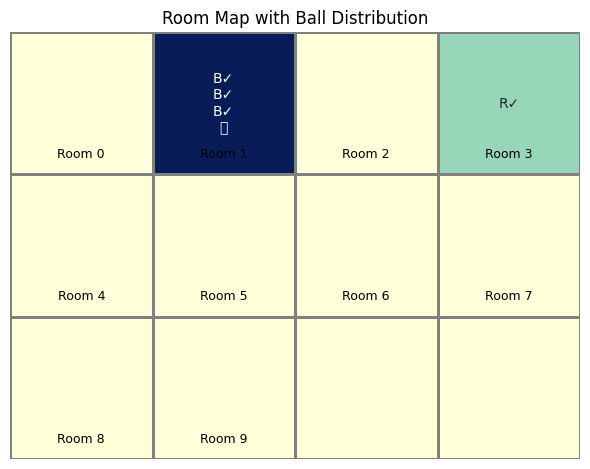

📌 Posterior belief: μ = 3.48, σ = 0.0211
Average reward: 3.4790000000000005
📌 Posterior belief: μ = 3.48, σ = 0.0211


In [8]:
num_episodes = 100
average_reward = 0
average_setps = 0
reward_list = []
est = BayesianRewardEstimator(mu0=0.0, sigma0=1.5, obs_sigma=1.5) # 0.5
print(f"📌 Prior belief: μ₀ = {est.mu:.2f}, σ₀ = {est.sigma2 ** 0.5:.4f}")
for x in range(num_episodes):
    env.found_balls = set()
    state = 0 #env.robot_room 
    total_reward = 0
    steps_taken = 0

    reward, steps = run_policy_with_detection(env, estimator=est)  # Ejecuta sin imprimir logs
    reward_list.append(reward)
    average_reward = average_reward + reward
    average_setps = average_setps + steps
    print(f"📌 Posterior belief: μ = {est.mu:.2f}, σ = {est.sigma2 ** 0.5:.4f}")
        
print("Average reward: "+ str(average_reward/num_episodes))
print(f"📌 Posterior belief: μ = {est.mu:.2f}, σ = {est.sigma2 ** 0.5:.4f}")

In [9]:
print("Average reward: "+ str(average_reward/num_episodes))
print("Average steps: "+ str(average_setps/num_episodes))
print(f"📌 Posterior belief: μ = {est.mu:.2f}, σ = {est.sigma2 ** 0.5:.4f}")
print("real obs sigma: "+str(calculate_obs_sigma(reward_list)))

Average reward: 3.4790000000000005
Average steps: 10.42
📌 Posterior belief: μ = 3.48, σ = 0.0211
real obs sigma: 0.1255653880122489


## TRAINING Q TABLE

In [10]:
import random
import numpy as np

est_qtable = BayesianRewardEstimator(mu0=0.0, sigma0=1.5, obs_sigma=0.1)
print(f"📌 Prior belief: μ₀ = {est_qtable.mu:.2f}, σ₀ = {est_qtable.sigma2 ** 0.5:.4f}")
q_table = np.zeros((env.num_rooms, env.num_rooms))  # Q[state, action]
alpha = 0.1     # learning rate
gamma = 0.9     # discount factor
epsilon = 0.2   # exploration rate
episodes = 500    # ⬅️ solo 5 episodios

#env = BallEnv()
max_steps = 100
for episode in range(episodes):
    #state = env.reset()
    # RESET NUMBER OF BALLS FOUND
    env.found_balls = set()
    state = 0 #env.robot_room 
    total_reward = 0
    steps_taken = 0

    for step in range(max_steps):
        if random.random() < epsilon:
            action = random.randint(0, env.num_rooms - 1)
        else:
            action = np.argmax(q_table[state])

        # ✅ Corrección:
        next_state, reward, done, _ = env.step(action)
        #est_qtable.update(reward)
        total_reward += reward

        # Q-learning update
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_value = old_value + alpha * (reward + gamma * next_max - old_value)
        q_table[state, action] = new_value

        state = next_state
        steps_taken += 1

        if done:
            break

    #print(f"Episode {episode+1}: Total Reward = {total_reward:.2f}, Steps Taken = {steps_taken}")

est_qtable.update(total_reward)
q_table
print("total reward: " + str(total_reward))
print(f"📌 Posterior belief: μ = {est_qtable.mu:.2f}, σ = {est_qtable.sigma2 ** 0.5:.4f}")

📌 Prior belief: μ₀ = 0.00, σ₀ = 1.5000
total reward: 3.55
📌 Posterior belief: μ = 3.53, σ = 0.0998


## Q TABLE HEATMAP

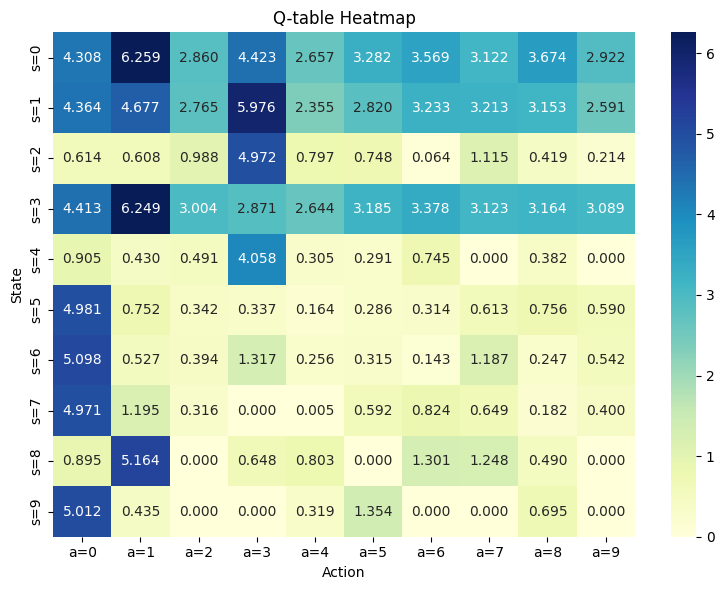

[[4.30817644e+00 6.25873254e+00 2.86013922e+00 4.42343201e+00
  2.65716110e+00 3.28247739e+00 3.56890784e+00 3.12172069e+00
  3.67433310e+00 2.92197409e+00]
 [4.36391193e+00 4.67693551e+00 2.76503477e+00 5.97640214e+00
  2.35530236e+00 2.81975563e+00 3.23270335e+00 3.21286937e+00
  3.15273803e+00 2.59102819e+00]
 [6.14188365e-01 6.07814827e-01 9.87536158e-01 4.97206282e+00
  7.97229973e-01 7.47733565e-01 6.42082606e-02 1.11511839e+00
  4.18500664e-01 2.14299659e-01]
 [4.41320319e+00 6.24879132e+00 3.00445681e+00 2.87071502e+00
  2.64448460e+00 3.18519294e+00 3.37822575e+00 3.12327385e+00
  3.16422515e+00 3.08904615e+00]
 [9.04652298e-01 4.30153826e-01 4.90528252e-01 4.05770663e+00
  3.04843497e-01 2.90734289e-01 7.44699997e-01 0.00000000e+00
  3.82266740e-01 0.00000000e+00]
 [4.98094873e+00 7.51502230e-01 3.42295120e-01 3.36733704e-01
  1.64000436e-01 2.86492886e-01 3.14126447e-01 6.12771597e-01
  7.55606805e-01 5.90386272e-01]
 [5.09776054e+00 5.26598581e-01 3.94183389e-01 1.31745646e

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tu Q-table (puedes reemplazar esto con la tuya si ya está entrena

# Crear un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(q_table, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,
            xticklabels=[f"a={i}" for i in range(q_table.shape[1])],
            yticklabels=[f"s={i}" for i in range(q_table.shape[0])])

plt.title("Q-table Heatmap")
plt.xlabel("Action")
plt.ylabel("State")
plt.tight_layout()
plt.show()
print(q_table)

## PLOT BALL DISTRIBUTION OF EXPERIMENT SETUP

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_56452/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


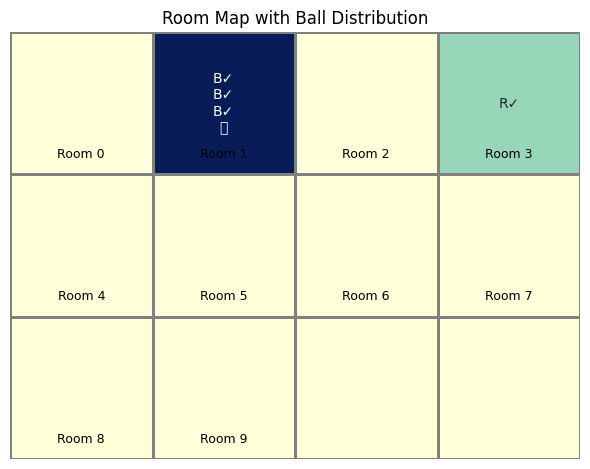

In [12]:
plot_room_ball_distribution(env)

## Calculate EU for some state action

In [13]:
def expected_utility(state, action, q_table, env, gamma=0.9):
    # Simulate what would happen by taking that action
    next_state = action  # action is the room to move to
    move_penalty = -0.05

    # Estimate detection reward (if a ball is present and detected)
    has_ball = any(
        room == next_state and i not in env.found_balls
        for i, (_, room) in enumerate(env.balls)
    )
    expected_reward = move_penalty
    if has_ball:
        expected_reward += env.p_detect * 1.0  # expected ball reward

    future_utility = gamma * np.max(q_table[next_state])
    return expected_reward + future_utility


In [14]:
u = expected_utility(state=0, action=1, q_table=q_table, env=env)
print(f"Expected utility of moving from Room 0 to 1: {u:.2f}")


Expected utility of moving from Room 0 to 1: 5.33


## GET AVERAGE REWARD OVER MANY TIMES RUNNING POLICY 1

## Q learning over many episodes average

In [15]:
def experiment_average_total_reward_q(env_class, q_table, runs=20, max_steps=50):
    #est_qtable = BayesianRewardEstimator(mu0=3.75, sigma0=0.09, obs_sigma=0.09)
    est_qtable = BayesianRewardEstimator(mu0=3.75, sigma0=1.5, obs_sigma=0.3)


    total_rewards = []
    total_steps = []
    average_steps = 0

    for _ in range(runs):
        '''
        env = env_class()
        env.set_blue_cluster_prob(0.9)
        env.set_detection_params(p_detect=0.9, p_explore=0.1)
        
        # Opcional: fully connect env
        env.set_connections({i: list(range(env.num_rooms)) for i in range(env.num_rooms)})
        '''
        # Para resetear las posiciones de las bolas aleatoriamente.
        #env.balls = []
        #env.reset()
        
        state = 0
        total_reward = 0
        steps_taken = 0
        env.found_balls = set()
        done = False

        while steps_taken < max_steps and not done:
            # Elegir acción con mejor Q-value
            next_room = int(np.argmax(q_table[state]))

            # Si no hay conexión, elegir al azar (fallback)
            if next_room not in env.connections[state]:
                candidates = [r for r in env.connections[state] if r != state]
                next_room = random.choice(candidates) if candidates else state

            state, reward, done, _ = env.step(next_room)
            total_reward += reward
            steps_taken += 1

        total_rewards.append(total_reward)
        total_steps.append(steps_taken)
        print(total_reward)
        est_qtable.update(total_reward)
        
    average_reward = sum(total_rewards) / runs
    average_steps = sum(total_steps) / runs
    
    return average_reward, total_rewards, average_steps


avg_q, rewards_q , average_steps= experiment_average_total_reward_q(BallEnvDetectable, q_table, runs=10)
print(f"📊 Q-policy average reward: {avg_q:.2f}")
print("Average number of steps: "+str(average_steps))
#est_qtable.update(avg_q)
print(f"📌 Posterior belief: μ = {est_qtable.mu:.2f}, σ = {est_qtable.sigma2 ** 0.5:.4f}")

3.75
3.6500000000000004
3.75
3.75
3.75
3.75
3.6500000000000004
3.75
3.6500000000000004
3.75
📊 Q-policy average reward: 3.72
Average number of steps: 5.6
📌 Posterior belief: μ = 3.53, σ = 0.0998



📊 Q-policy average reward: 3.73
Average number of steps: 5.4
📌 Posterior belief: μ = 3.74, σ = 0.0133


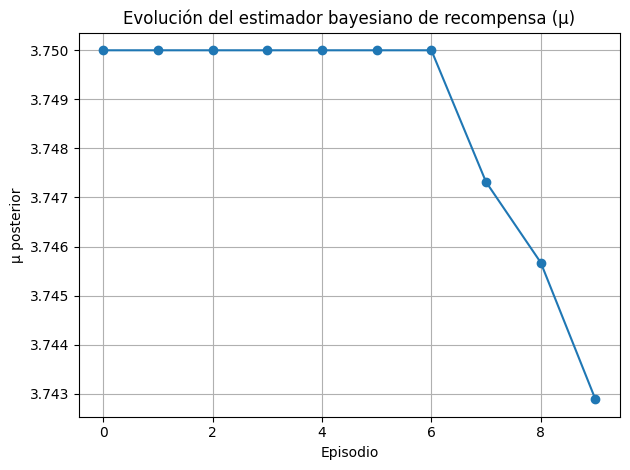

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt



def experiment_average_total_reward_q(env, q_table, runs=20, max_steps=50):
    #est_qtable = BayesianRewardEstimator(mu0=3.75, sigma0=1.5, obs_sigma=0.3)
    #est_qtable = BayesianRewardEstimator(mu0=3.75, sigma0=0.09, obs_sigma=0.09)
    est_qtable = BayesianRewardEstimator(mu0=3.75, sigma0=0.09, obs_sigma=0.1)

    total_rewards = []
    total_steps = []
    mu_evolution = []

    for _ in range(runs):
        state = 0
        total_reward = 0
        steps_taken = 0
        env.found_balls = set()
        done = False

        while steps_taken < max_steps and not done:
            next_room = int(np.argmax(q_table[state]))

            # Si no hay conexión, fallback aleatorio
            if next_room not in env.connections[state]:
                candidates = [r for r in env.connections[state] if r != state]
                next_room = random.choice(candidates) if candidates else state

            state, reward, done, _ = env.step(next_room)
            total_reward += reward
            steps_taken += 1

        total_rewards.append(total_reward)
        total_steps.append(steps_taken)

        #print(total_reward)
        est_qtable.update(total_reward)
        mu_evolution.append(est_qtable.mu)

    average_reward = sum(total_rewards) / runs
    average_steps = sum(total_steps) / runs

    return average_reward, total_rewards, average_steps, est_qtable, mu_evolution


# 🔁 Ejecutar experimento
avg_q, rewards_q, average_steps, est_qtable, mu_evolution = experiment_average_total_reward_q(
    env=env,  # tu entorno ya creado (BallEnvDetectable)
    q_table=q_table,
    runs=10
)

# 📈 Mostrar resultados
print(f"\n📊 Q-policy average reward: {avg_q:.2f}")
print("Average number of steps:", average_steps)
print(f"📌 Posterior belief: μ = {est_qtable.mu:.2f}, σ = {est_qtable.sigma2 ** 0.5:.4f}")

# 📉 Gráfico evolución de μ
plt.plot(mu_evolution, marker='o')
plt.title("Evolución del estimador bayesiano de recompensa (μ)")
plt.xlabel("Episodio")
plt.ylabel("μ posterior")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
def compute_score(mu, sigma, steps):
    return mu / (steps * sigma)

score_policy1 = compute_score(3.65, 0.01, 6.77)
score_q = compute_score(0.56, 0.01, 50)

print("Policy 1 Score:", score_policy1)
print("Q Policy Score:", score_q)

best_policy = "Policy 1" if score_policy1 > score_q else "Q Policy"
print(f"Best policy to use: {best_policy}")


Policy 1 Score: 53.91432791728213
Q Policy Score: 1.12
Best policy to use: Policy 1


## CORRELATION STUDY

In [18]:
colors = [color for color, _ in env.balls]
print(colors)
import pandas as pd

df = pd.DataFrame(colors, columns=["color"])
df["color_code"] = df["color"].map({"blue": 1, "red": 0})  # or use .astype("category").cat.codes
room_color_counts = pd.DataFrame(env.balls, columns=["color", "room"])
grouped = room_color_counts.groupby("room")["color"].value_counts().unstack(fill_value=0)
correlation = grouped.corr()
print(correlation)

['blue', 'blue', 'blue', 'red']
color  blue  red
color           
blue    1.0 -1.0
red    -1.0  1.0


(                num_rooms  num_blue_balls  num_red_balls  total_balls  \
 num_rooms        1.000000       -0.135627      -0.107675    -0.178079   
 num_blue_balls  -0.135627        1.000000      -0.085076     0.853937   
 num_red_balls   -0.107675       -0.085076       1.000000     0.445840   
 total_balls     -0.178079        0.853937       0.445840     1.000000   
 cluster_prob     0.042278       -0.014671       0.186020     0.083972   
 steps           -0.002637        0.182472      -0.245544     0.035687   
 average_reward  -0.005643        0.052048       0.054514     0.075229   
 
                 cluster_prob     steps  average_reward  
 num_rooms           0.042278 -0.002637       -0.005643  
 num_blue_balls     -0.014671  0.182472        0.052048  
 num_red_balls       0.186020 -0.245544        0.054514  
 total_balls         0.083972  0.035687        0.075229  
 cluster_prob        1.000000  0.019948        0.057388  
 steps               0.019948  1.000000        0.509646  


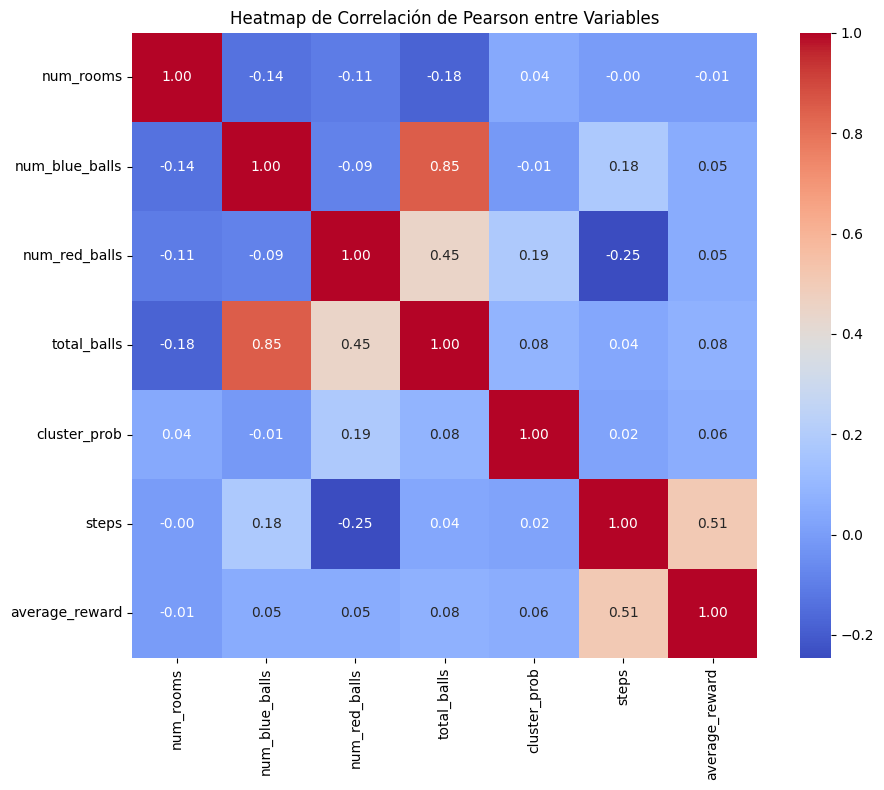

In [19]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Simulate 30 new experiments adding cluster_prob
data = []
for _ in range(30):
    num_rooms = random.choice([4, 6, 8, 10])
    num_blue = random.randint(1, 5)
    num_red = random.randint(1, 3)
    cluster_prob = random.uniform(0, 1)
    total_balls = num_blue + num_red

    steps = random.randint(10, 50)
    reward = round(random.uniform(0.3, 4.0) - 0.05 * (num_rooms - 4) + 0.1 * (cluster_prob - 0.5), 2)
    reward = max(0, reward)

    data.append({
        "num_rooms": num_rooms,
        "num_blue_balls": num_blue,
        "num_red_balls": num_red,
        "total_balls": total_balls,
        "cluster_prob": cluster_prob,
        "steps": steps,
        "average_reward": reward
    })

df = pd.DataFrame(data)

# Pearson correlation
pearson_corr = df.corr(numeric_only=True)

# Chi-square test (discretize steps and rewards)
df['steps_bin'] = pd.qcut(df['steps'], q=3, duplicates='drop')
df['reward_bin'] = pd.qcut(df['average_reward'], q=3, duplicates='drop')
contingency = pd.crosstab(df['steps_bin'], df['reward_bin'])
chi2, p, _, _ = chi2_contingency(contingency)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Heatmap de Correlación de Pearson entre Variables")
plt.tight_layout()

pearson_corr, chi2, p


In [20]:
import numpy as np
from collections import defaultdict

transitions = ['π1', 'π2', 'π1', 'π2', 'π1', 'π2','π1', 'π1', 'π1', 'π2', 'π1', 'π2']
counts = defaultdict(lambda: {'π1': 0, 'π2': 0})

for a, b in zip(transitions[:-1], transitions[1:]):
    counts[a][b] += 1

policies = ['π1', 'π2']
P = np.zeros((2, 2))

for i, pi_from in enumerate(policies):
    total = sum(counts[pi_from].values())
    for j, pi_to in enumerate(policies):
        P[i, j] = counts[pi_from][pi_to] / total if total > 0 else 0

print("Transition matrix:\n", P)


Transition matrix:
 [[0.28571429 0.71428571]
 [1.         0.        ]]


In [21]:
import numpy as np


def is_regular(P, max_k=100):
    n = P.shape[0]
    Pk = np.copy(P)
    for k in range(1, max_k+1):
        if np.all(Pk > 0):  # all elements strictly positive
            return True, k
        Pk = Pk @ P  # multiply again
    return False, None

regular, k = is_regular(P)
if regular:
    print(f"✅ Markov Chain is regular (P^{k} is strictly positive)")
else:
    print("❌ Markov Chain is NOT regular")


✅ Markov Chain is regular (P^2 is strictly positive)


In [22]:
import numpy as np

# Set convergence threshold
tolerance = 1e-6
max_iterations = 100
prev = P.copy()

print("Checking convergence of powers of P:")

for i in range(1, max_iterations + 1):
    prev_next = prev @ P  # Matrix multiplication

    # Check if difference between prev and prev_next is small enough
    if np.allclose(prev_next, prev, atol=tolerance):
        print(f"\n✅ Converged at step {i+1}")
        print(f"P^{i+1} ≈\n{prev_next}")
        break

    prev = prev_next
    print(f"P^{i+1}:\n{prev}\n")
else:
    print("\n⚠️ Did not converge within the max iterations.")


Checking convergence of powers of P:
P^2:
[[0.79591837 0.20408163]
 [0.28571429 0.71428571]]

P^3:
[[0.43148688 0.56851312]
 [0.79591837 0.20408163]]

P^4:
[[0.69179509 0.30820491]
 [0.43148688 0.56851312]]

P^5:
[[0.50586065 0.49413935]
 [0.69179509 0.30820491]]

P^6:
[[0.63867096 0.36132904]
 [0.50586065 0.49413935]]

P^7:
[[0.54380646 0.45619354]
 [0.63867096 0.36132904]]

P^8:
[[0.61156682 0.38843318]
 [0.54380646 0.45619354]]

P^9:
[[0.56316656 0.43683344]
 [0.61156682 0.38843318]]

P^10:
[[0.59773817 0.40226183]
 [0.56316656 0.43683344]]

P^11:
[[0.57304416 0.42695584]
 [0.59773817 0.40226183]]

P^12:
[[0.59068274 0.40931726]
 [0.57304416 0.42695584]]

P^13:
[[0.57808376 0.42191624]
 [0.59068274 0.40931726]]

P^14:
[[0.58708303 0.41291697]
 [0.57808376 0.42191624]]

P^15:
[[0.58065498 0.41934502]
 [0.58708303 0.41291697]]

P^16:
[[0.58524644 0.41475356]
 [0.58065498 0.41934502]]

P^17:
[[0.58196683 0.41803317]
 [0.58524644 0.41475356]]

P^18:
[[0.58430941 0.41569059]
 [0.58196683

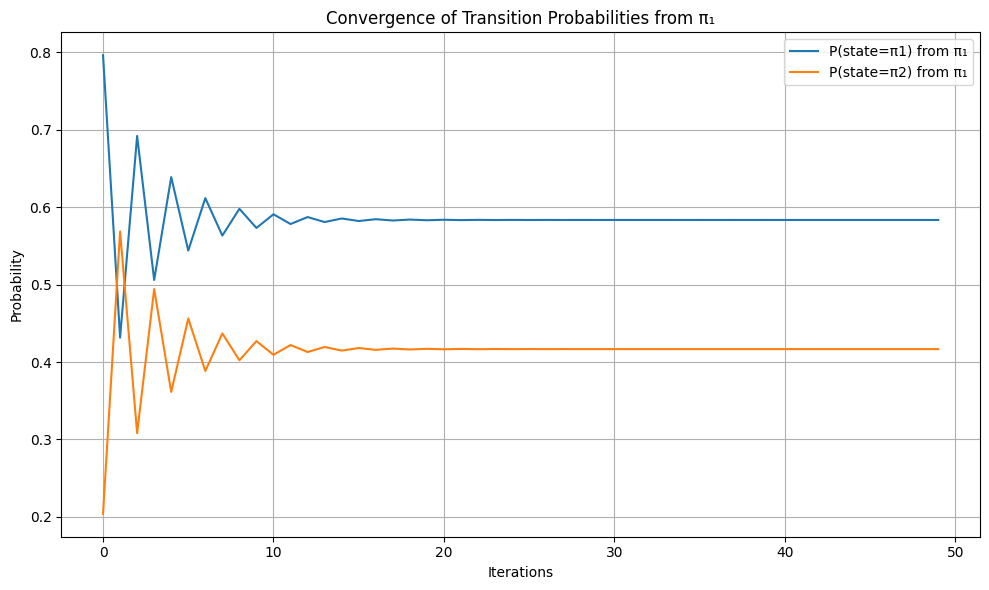

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Example transition matrix (update with your own if needed)
P = np.array([[0.28571429, 0.71428571],
              [1.0,        0.0]])

# Track how rows evolve over iterations
num_iterations = 50
row_history = []

current = P.copy()
for i in range(num_iterations):
    current = current @ P
    row_history.append(current[0])  # track evolution from first row

row_history = np.array(row_history)

# Plot evolution of each state probability from initial state π1
plt.figure(figsize=(10, 6))
for i in range(P.shape[1]):
    plt.plot(row_history[:, i], label=f"P(state=π{i+1}) from π₁")

plt.title("Convergence of Transition Probabilities from π₁")
plt.xlabel("Iterations")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Markov chain for Q table

In [54]:
import numpy as np

def mc_irregularity_cost(P, k=10):
    """
    Computes a cost for MC irregularity based on zero entries in P^k.
    
    Parameters:
        P (np.ndarray): Transition matrix (n x n)
        k (int): Power to raise the matrix to (default=10)
        
    Returns:
        float: Irregularity cost (0 = fully regular, 1 = highly irregular)
    """
    Pk = np.linalg.matrix_power(P, k)
    num_zero_entries = np.sum(Pk == 0)
    total_entries = Pk.size
    cost = num_zero_entries / total_entries
    return cost

# Example usage:
# P is your transition matrix
# P = np.array(...)  # already defined

In [24]:
import numpy as np

def normalized_entropy(p):
    """
    Compute the normalized entropy of a probability distribution.
    
    Parameters:
        p (np.ndarray): A probability distribution (e.g., stationary distribution)
        
    Returns:
        float: Normalized entropy between 0 and 1
    """
    p = np.array(p)
    p = p[p > 0]  # filter out zero entries to avoid log(0)
    entropy = -np.sum(p * np.log(p))
    max_entropy = np.log(len(p))
    return entropy / max_entropy if max_entropy > 0 else 0.0


In [25]:
def compute_oscillation_cost(P, power=100):
    """
    Compute the oscillation cost as the std of difference between P^n and P^{n-1}.
    """
    P_n_minus_1 = np.linalg.matrix_power(P, power - 1)
    P_n = np.linalg.matrix_power(P, power)
    return np.std(P_n - P_n_minus_1)

In [26]:
import numpy as np

def steps_until_stationary(P, tol=1e-8, max_iter=1000):
    """
    Returns the number of steps needed until convergence to the stationary distribution.

    Parameters:
        P (np.ndarray): The transition matrix (n x n)
        tol (float): Convergence threshold (e.g., 1e-8)
        max_iter (int): Maximum number of iterations

    Returns:
        steps (int): Number of steps until convergence
        stationary (np.ndarray): Approximated stationary distribution
    """
    n = P.shape[0]
    current = np.copy(P)
    
    for step in range(1, max_iter + 1):
        next_P = current @ P  # one more step
        # Check if all rows are close to each other (i.e., converged)
        diffs = np.max(np.abs(next_P - next_P[0, :]), axis=1)
        if np.all(diffs < tol):
            return step, next_P[0, :]  # Stationary distribution
        current = next_P
    
    print("Warning: Did not converge within max_iter steps.")
    return max_iter, current[0, :]

In [27]:
policy = np.argmax(q_table, axis=1)

In [28]:
print(policy)

[1 3 3 1 3 0 0 0 1 0]


In [29]:
num_states = q_table.shape[0]

In [30]:
# Cadena de Markov inducida por la política
P = np.zeros((num_states, num_states))
for s in range(num_states):
    a = policy[s]
    P[s, a] = 1.0  # determinista: desde s, s

In [31]:
P

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

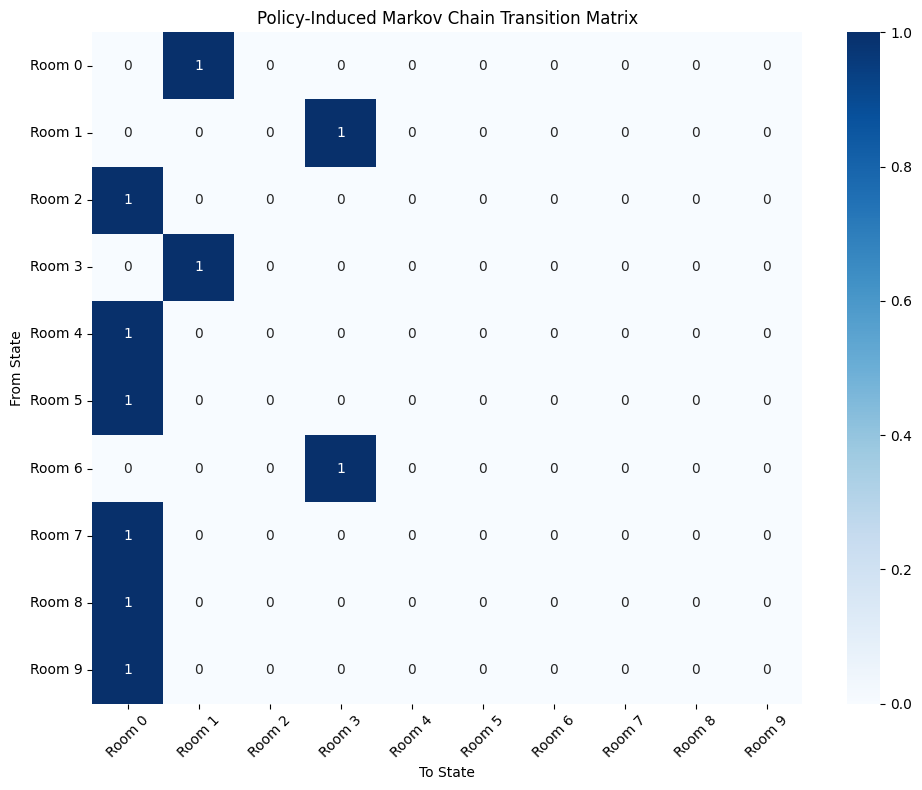

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Transition matrix (from Q-table derived policy)
P = np.array([
    [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
])

# State names for axis labels
state_names = [f"Room {i}" for i in range(P.shape[0])]

# Create a DataFrame for the heatmap
df = pd.DataFrame(P, index=state_names, columns=state_names)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap="Blues", cbar=True, fmt=".0f")
plt.title("Policy-Induced Markov Chain Transition Matrix")
plt.ylabel("From State")
plt.xlabel("To State")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [33]:
'''
Analizar convergencia (steady-state).
Detectar ciclos u oscilaciones.
Ver si hay estados absorbentes o recurrentes.
Usar teoría de cadenas de Markov para evaluar la política sin simulación.
'''

'\nAnalizar convergencia (steady-state).\nDetectar ciclos u oscilaciones.\nVer si hay estados absorbentes o recurrentes.\nUsar teoría de cadenas de Markov para evaluar la política sin simulación.\n'

In [34]:
regular, k = is_regular(P)
if regular:
    print(f"✅ Markov Chain is regular (P^{k} is strictly positive)")
else:
    print("❌ Markov Chain is NOT regular")

❌ Markov Chain is NOT regular


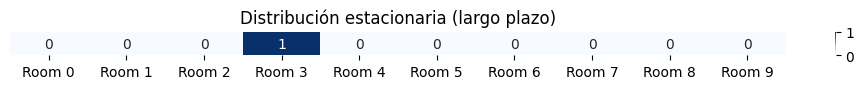

Stationary matrix


In [35]:
# Elevar la matriz a una gran potencia para aproximar la distribución estacionaria
P_stationary = np.linalg.matrix_power(P, 100)

# Tomar cualquier fila como distribución estacionaria (todas son iguales en una cadena regular)
stationary_distribution = P_stationary[0]

# Mostrar la distribución estacionaria como heatmap
plt.figure(figsize=(10, 1))
sns.heatmap([stationary_distribution], annot=True, cmap="Blues", xticklabels=[f"Room {i}" for i in range(10)])
plt.title("Distribución estacionaria (largo plazo)")
plt.yticks([])
plt.tight_layout()
plt.show()

print("Stationary matrix")


In [69]:

normalized_H = normalized_entropy(stationary_distribution)
print(f"🔢 Normalized Entropy of Stationary Distribution penalty: {normalized_H:.4f}")


🔢 Normalized Entropy of Stationary Distribution penalty: 0.9995


In [37]:
steps_until_stationary(P)

(1000, array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [38]:
osc_cost = compute_oscillation_cost(P, power=100)
print(f"🔁 Oscillation cost: {osc_cost:.6f}")

🔁 Oscillation cost: 0.447214


In [55]:

cost = mc_irregularity_cost(P, k=10)
print(f"🧮 Irregularity Cost (based on P^{10}): {cost:.4f}")


🧮 Irregularity Cost (based on P^10): 0.9000


In [40]:
import numpy as np
import networkx as nx

def find_closed_classes(P, tol=1e-12):
    """
    Given a transition matrix P, returns the list of closed communicating classes
    (i.e., functionally absorbing sets of states).

    Parameters:
        P (np.ndarray): Transition matrix (square, row-stochastic).
        tol (float): Tolerance for considering an entry as non-zero.

    Returns:
        List of sets: each set is a closed communicating class.
    """
    n = P.shape[0]
    G = nx.DiGraph()

    # Add edges for positive probabilities
    for i in range(n):
        for j in range(n):
            if P[i, j] > tol:
                G.add_edge(i, j)

    # Find strongly connected components (SCCs)
    sccs = list(nx.strongly_connected_components(G))

    # Identify closed SCCs: no outgoing edges to outside the component
    closed_classes = []
    for scc in sccs:
        has_outgoing = False
        for node in scc:
            successors = set(G.successors(node))
            if successors - scc:
                has_outgoing = True
                break
        if not has_outgoing:
            closed_classes.append(scc)

    return closed_classes

In [41]:
closed = find_closed_classes(P)
print("Closed (functionally absorbing) classes:")
for cls in closed:
    print(sorted(cls))

Closed (functionally absorbing) classes:
[1, 3]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


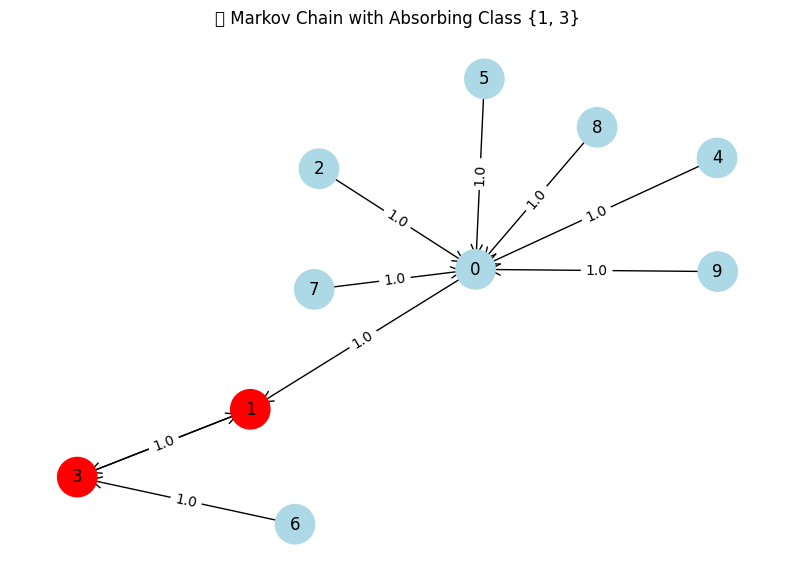

In [42]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Example transition matrix (10 states)
P = np.array([
    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
])

G = nx.DiGraph()

# Create edges from transition matrix
num_states = P.shape[0]
for i in range(num_states):
    for j in range(num_states):
        if P[i, j] > 0:
            G.add_edge(i, j, weight=P[i, j])

# Node coloring: absorbing class in red
node_colors = []
absorbing_class = {1, 3}
for node in G.nodes:
    if node in absorbing_class:
        node_colors.append("red")
    else:
        node_colors.append("lightblue")

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800)
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=12)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.1f}" for k, v in edge_labels.items()})
plt.title("🔁 Markov Chain with Absorbing Class {1, 3}")
plt.axis("off")
plt.show()


## MARKOV CHAIN FOR POLICY 1:

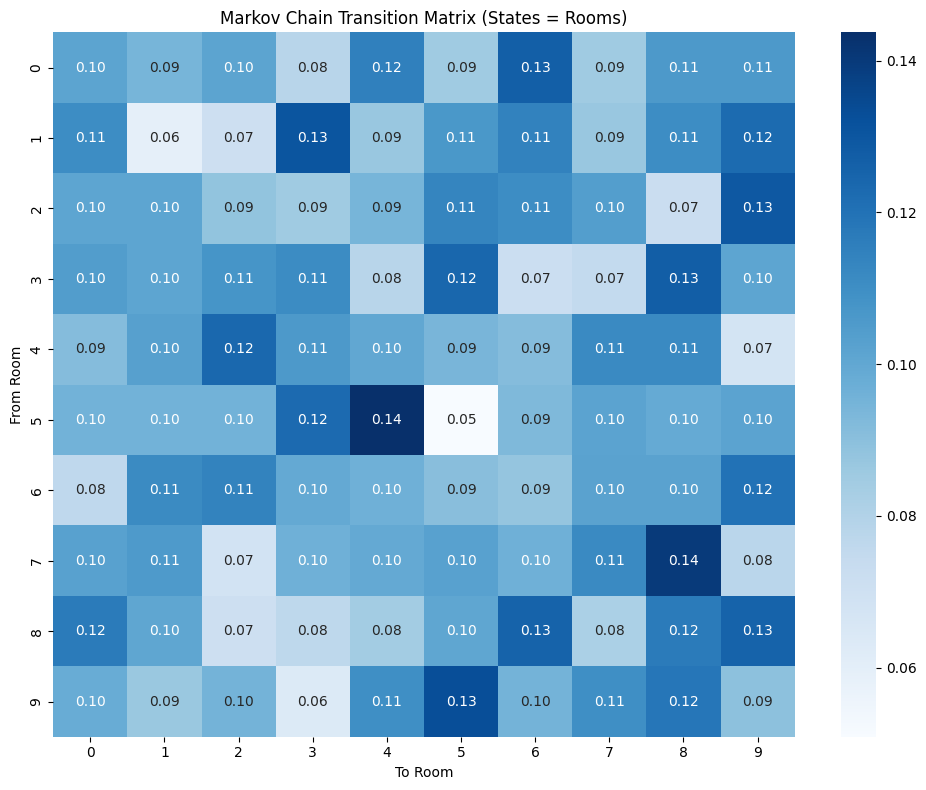

array([[0.10138249, 0.09447005, 0.10138249, 0.07834101, 0.11520737,
        0.08525346, 0.12672811, 0.08525346, 0.10599078, 0.10599078],
       [0.11067194, 0.05928854, 0.07114625, 0.13043478, 0.08695652,
        0.10671937, 0.11462451, 0.08695652, 0.11067194, 0.12252964],
       [0.10094637, 0.10094637, 0.08832808, 0.0851735 , 0.09463722,
        0.11356467, 0.11041009, 0.10410095, 0.07255521, 0.12933754],
       [0.10423453, 0.1009772 , 0.10749186, 0.11074919, 0.0781759 ,
        0.1237785 , 0.07166124, 0.07491857, 0.12703583, 0.1009772 ],
       [0.09117647, 0.10294118, 0.12352941, 0.10588235, 0.1       ,
        0.09411765, 0.09117647, 0.11176471, 0.11176471, 0.06764706],
       [0.09580838, 0.09580838, 0.09580838, 0.12275449, 0.14371257,
        0.0508982 , 0.09281437, 0.10179641, 0.0988024 , 0.10179641],
       [0.07602339, 0.11111111, 0.11403509, 0.0994152 , 0.09649123,
        0.09064327, 0.0877193 , 0.10233918, 0.10233918, 0.11988304],
       [0.10248447, 0.10559006, 0.0683229

In [68]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

MOVE_PENALTY = -0.05
FIND_REWARD = 1.0

class BallEnvDetectable:
    def __init__(self, num_rooms=4, num_blue=3, num_red=1):
        self.num_rooms = num_rooms
        self.num_blue = num_blue
        self.num_red = num_red
        self.balls = []
        self.found_balls = set()
        self.robot_room = 0
        self.blue_cluster_prob = 0.9
        self.p_detect = 0.9
        self.p_explore = 0.1
        self.connections = self._default_connections()

    def _default_connections(self):
        return {i: [j for j in range(self.num_rooms) if j != i] for i in range(self.num_rooms)}

    def set_blue_cluster_prob(self, prob: float):
        self.blue_cluster_prob = prob

    def set_detection_params(self, p_detect: float, p_explore: float):
        self.p_detect = p_detect
        self.p_explore = p_explore

    def set_manual_ball_positions(self, positions):
        self.balls = positions.copy()
        self.found_balls = set()

    def set_connections(self, connections):
        self.connections = connections

    def reset(self):
        self.found_balls = set()
        if not self.balls:
            self.balls = []
            if random.random() < self.blue_cluster_prob:
                blue_room = random.randint(0, self.num_rooms - 1)
                for _ in range(self.num_blue):
                    self.balls.append(('blue', blue_room))
            else:
                for _ in range(self.num_blue):
                    self.balls.append(('blue', random.randint(0, self.num_rooms - 1)))
            for _ in range(self.num_red):
                self.balls.append(('red', random.randint(0, self.num_rooms - 1)))
        self.robot_room = 0
        return self.robot_room

    def detect_ball(self):
        for i, (color, room) in enumerate(self.balls):
            if room == self.robot_room and i not in self.found_balls:
                if random.random() < self.p_detect:
                    return i, color
        return None

    def step(self, target_room):
        if target_room not in self.connections.get(self.robot_room, []):
            raise ValueError(f"Invalid move: no connection from Room {self.robot_room} to Room {target_room}")
        reward = MOVE_PENALTY
        self.robot_room = target_room
        ball_found = None
        for i, (color, room) in enumerate(self.balls):
            if room == self.robot_room and i not in self.found_balls:
                if random.random() < self.p_detect:
                    self.found_balls.add(i)
                    reward += FIND_REWARD
                    ball_found = (i, color)
                break
        done = len(self.found_balls) == len(self.balls)
        return self.robot_room, reward, done, ball_found

# Parámetros de entorno
NUM_ROOMS = 10
env = BallEnvDetectable(NUM_ROOMS, num_blue=3, num_red=1)
env.set_blue_cluster_prob(0.9)
env.set_detection_params(p_detect=0.9, p_explore=0.0)
env.set_connections({i: list(range(NUM_ROOMS)) for i in range(NUM_ROOMS)})
env.set_manual_ball_positions([
    ('blue', 1), ('blue', 1), ('blue', 1),
    ('red', 3)
])

# Simulación y recopilación de transiciones
transition_counts = np.zeros((NUM_ROOMS, NUM_ROOMS))
num_episodes = 100

for _ in range(num_episodes):
    state = env.reset()
    for _ in range(50):
        next_state = random.choice(env.connections[state])
        new_state, reward, done, _ = env.step(next_state)
        transition_counts[state, new_state] += 1
        state = new_state
        if done:
            break

# Normalizar para obtener la matriz de transición
row_sums = transition_counts.sum(axis=1, keepdims=True)
transition_matrix = transition_counts / np.maximum(row_sums, 1)

# Graficar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(NUM_ROOMS), yticklabels=range(NUM_ROOMS))
plt.title("Markov Chain Transition Matrix (States = Rooms)")
plt.xlabel("To Room")
plt.ylabel("From Room")
plt.tight_layout()
plt.show()
transition_matrix

In [44]:
regular, k = is_regular(transition_matrix)
if regular:
    print(f"✅ Markov Chain is regular (P^{k} is strictly positive)")
else:
    print("❌ Markov Chain is NOT regular")

✅ Markov Chain is regular (P^1 is strictly positive)


In [45]:

closed = find_closed_classes(transition_matrix)
print("Closed (functionally absorbing) classes:")
for cls in closed:
    print(sorted(cls))

Closed (functionally absorbing) classes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


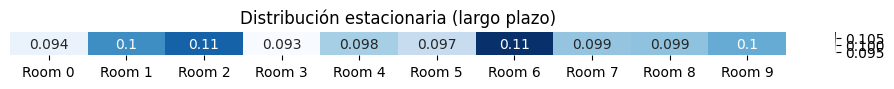

Stationary matrix


array([0.09366087, 0.10331177, 0.10609852, 0.09255529, 0.09842117,
       0.09658648, 0.10937348, 0.09932072, 0.09947736, 0.10119433])

In [46]:


# Elevar la matriz a una gran potencia para aproximar la distribución estacionaria
P_stationary = np.linalg.matrix_power(transition_matrix, 100)

# Tomar cualquier fila como distribución estacionaria (todas son iguales en una cadena regular)
stationary_distribution = P_stationary[0]

# Mostrar la distribución estacionaria como heatmap
plt.figure(figsize=(10, 1))
sns.heatmap([stationary_distribution], annot=True, cmap="Blues", xticklabels=[f"Room {i}" for i in range(10)])
plt.title("Distribución estacionaria (largo plazo)")
plt.yticks([])
plt.tight_layout()
plt.show()

print("Stationary matrix")
stationary_distribution


In [47]:
steps_until_stationary(transition_matrix)

(6,
 array([0.09366087, 0.10331177, 0.10609852, 0.09255529, 0.09842117,
        0.09658648, 0.10937348, 0.09932072, 0.09947736, 0.10119433]))

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_markov_convergence_no_pca(P, steps=100, tol=1e-8, selected_states=[0, 1, 2]):
    """
    Plots the convergence of selected state probabilities over time (no PCA).
    
    Parameters:
        P (np.ndarray): Transition matrix (n x n)
        steps (int): Number of steps to simulate
        tol (float): Convergence tolerance
        selected_states (list): Indices of states to visualize
    """
    n = P.shape[0]
    dist = np.ones(n) / n  # start from uniform
    history = [dist.copy()]
    
    for _ in range(steps):
        dist = dist @ P
        history.append(dist.copy())
        if np.linalg.norm(history[-1] - history[-2], ord=1) < tol:
            break
    
    history = np.array(history)
    time = np.arange(len(history))
    
    plt.figure(figsize=(10, 6))
    for i in selected_states:
        plt.plot(time, history[:, i], label=f"State {i}")
    
    plt.title("Markov Chain Convergence Over Time")
    plt.xlabel("Step")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Converged in {len(history)} steps.")

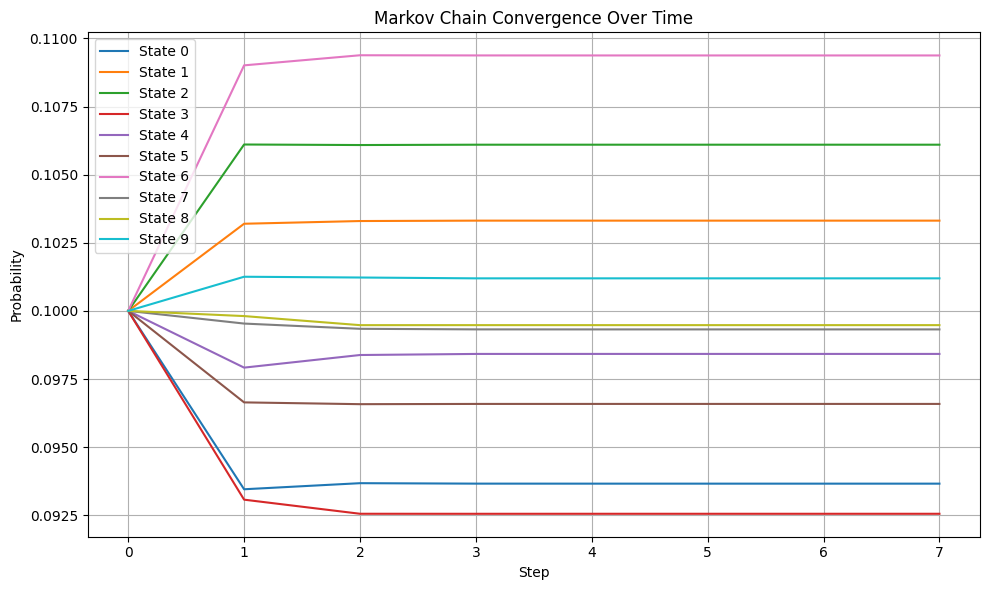

Converged in 8 steps.


In [49]:

plot_markov_convergence_no_pca(transition_matrix, steps=100, selected_states=[0,1,2, 3,4, 5, 6,7,8,9])


In [56]:
cost = mc_irregularity_cost(transition_matrix, k=10)
print(f"🧮 Irregularity Cost (based on P^{10}): {cost:.4f}")


🧮 Irregularity Cost (based on P^10): 0.0000


In [51]:
osc_cost = compute_oscillation_cost(transition_matrix, power=100)
print(f"🔁 Oscillation cost: {osc_cost:.6f}")

🔁 Oscillation cost: 0.000000


In [59]:
normalized_H = normalized_entropy(stationary_distribution)
entropy_penalty = 1 - normalized_H  # Normalized to [0, 1]
print(f"🔢 Normalized Entropy of Stationary Distribution penalty: {normalized_H:.4f}")


🔢 Normalized Entropy of Stationary Distribution penalty: 0.9995


In [53]:
'''
Strategy to Implement:
For each policy:
Track the transition matrix 
​	
 .
Check if it's regular (eventually strictly positive).
Compute or update the stationary distribution.
Policy Switch Trigger:
If stationary distribution drifts significantly from expected (e.g., via KL-divergence or L2 distance).
If matrix becomes non-regular or enters a loop.
Switch:
Choose the alternative policy whose MC is more regular, stable, or aligned with a reward-maximizing state.
'''

"\nStrategy to Implement:\nFor each policy:\nTrack the transition matrix \n\u200b\t\n .\nCheck if it's regular (eventually strictly positive).\nCompute or update the stationary distribution.\nPolicy Switch Trigger:\nIf stationary distribution drifts significantly from expected (e.g., via KL-divergence or L2 distance).\nIf matrix becomes non-regular or enters a loop.\nSwitch:\nChoose the alternative policy whose MC is more regular, stable, or aligned with a reward-maximizing state.\n"

In [62]:
instability_cost = w1 * C_irregular + w2 * oscillation_cost + w3 * entropy_penalty
EVC = expected_reward - instability_cost


NameError: name 'w1' is not defined

In [63]:
instability_cost = 1.0 * 0.3 + 1.0 * 0.4 + 0.5 * 0.2 = 0.3 + 0.4 + 0.1 = 0.8
EVC = 3.8 - 0.8 = 3.0


SyntaxError: cannot assign to expression (2126766160.py, line 1)

In [64]:
meta_score = mu / (steps * sigma)
instability_cost = w1 * C_irregular + w2 * oscillation_cost + w3 * entropy_penalty
meta_evc = lambda_ * meta_score - instability_cost


NameError: name 'mu' is not defined